# Phase 3: Model Development

## Deep Learning Models for Climate-Food Security Prediction

This notebook trains and evaluates three deep learning architectures on our **5-crop Nigerian agricultural dataset**:
- **FNN (Feedforward Neural Network)**: Annual aggregated data
- **LSTM (Long Short-Term Memory)**: Monthly time series
- **Hybrid Model**: LSTM + engineered features

**Dataset**: 5 optimal crops (Millet, Sorghum, Groundnuts, Oil palm fruit, Cocoa beans) × 6 zones × 34 years (1990-2023)

**Key Features**:
- Climate variables: Temperature, Rainfall, Humidity, CO2
- Soil properties: pH, Nitrogen, Phosphorus, Organic Carbon
- Regional scaling algorithm creates zone-level variation from national FAO data
- Strong North-South patterns (Millet/Sorghum/Groundnuts vs Oil palm/Cocoa)

---
## Setup and Imports

In [1]:
# Install TensorFlow (run the install cell at the top if needed)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import random
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf  # type: ignore
from tensorflow.keras import layers, models, callbacks, regularizers  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             mean_absolute_percentage_error, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Display settings

pd.set_option('display.max_columns', None)

# Check for GPUs and print status
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0} - {gpus}")

sns.set_style('whitegrid')

print(f"Random seed set to: {RANDOM_SEED}")

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

GPU available: False - []
Random seed set to: 42
✓ All libraries imported successfully!
TensorFlow version: 2.20.0


---
## Load Processed Data

In [2]:
# Define paths
data_path = Path('project_data')
splits_path = data_path / 'train_test_split'

# Define constants for 5-crop dataset
CROPS = ['Millet', 'Sorghum', 'Groundnuts', 'Oil palm fruit', 'Cocoa beans']
ZONES = ['North-West', 'North-East', 'North-Central', 'South-West', 'South-East', 'South-South']

print("="*80)
print("Loading train/validation/test splits...")
print(f"Crops: {len(CROPS)} - {CROPS}")
print(f"Zones: {len(ZONES)}")
print("="*80)

Loading train/validation/test splits...
Crops: 5 - ['Millet', 'Sorghum', 'Groundnuts', 'Oil palm fruit', 'Cocoa beans']
Zones: 6


In [3]:
# Function to categorize yields
def categorize_yield(yields, percentiles=None):
    """
    Categorize continuous yield values into Low/Medium/High classes
    """
    if percentiles is None:
        percentiles = [np.percentile(yields, 33.33), np.percentile(yields, 66.67)]
    
    categories = np.zeros(len(yields), dtype=int)
    categories[yields < percentiles[0]] = 0  # Low
    categories[(yields >= percentiles[0]) & (yields < percentiles[1])] = 1  # Medium
    categories[yields >= percentiles[1]] = 2  # High
    
    return categories, percentiles

print("✓ Yield categorization function defined")
print("Categories: 0=Low, 1=Medium, 2=High")

✓ Yield categorization function defined
Categories: 0=Low, 1=Medium, 2=High


### Define Yield Categories

We'll classify yields into three categories for classification metrics:
- **Low**: Below 33rd percentile
- **Medium**: Between 33rd and 67th percentile  
- **High**: Above 67th percentile

---
## Part 1: FNN (Feedforward Neural Network) Model

### 1.1 Load FNN Data

### Understanding FNN (Feedforward Neural Network)

**What is FNN?**
A Feedforward Neural Network is a traditional deep learning architecture where information flows in one direction—from input through hidden layers to output. Unlike recurrent networks, FNNs don't maintain memory of previous inputs.

**Why use FNN for crop yield prediction?**
- **Annual aggregated data**: FNN works well with tabular data where each row represents a complete growing season
- **Feature interactions**: Multiple dense layers can learn complex non-linear relationships between climate, soil, and yield
- **Simplicity**: Easier to train and interpret compared to sequence models

**Our FNN approach:**
- Input features: Climate averages (Temperature, Rainfall, Humidity, CO2), Soil properties (pH, Nitrogen, Phosphorus, Organic Matter), and categorical encodings (Crop, Zone)
- Architecture: 3 hidden layers (128→64→32 neurons) with BatchNormalization and Dropout for regularization
- Output: Single continuous value (yield in tonnes/ha)

In [4]:
print("\n📊 LOADING FNN DATA...")

# Load splits
fnn_train = pd.read_csv(splits_path / 'fnn' / 'train.csv')
fnn_val = pd.read_csv(splits_path / 'fnn' / 'val.csv')
fnn_test = pd.read_csv(splits_path / 'fnn' / 'test.csv')

print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")

# Check available columns
print(f"\n  Available columns: {list(fnn_train.columns)}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in fnn_train.columns:
    fnn_train['Yield_tonnes_per_ha'] = fnn_train['Yield_kg_per_ha'] / 1000
    fnn_val['Yield_tonnes_per_ha'] = fnn_val['Yield_kg_per_ha'] / 1000
    fnn_test['Yield_tonnes_per_ha'] = fnn_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
fnn_train = fnn_train.dropna(subset=['Yield_tonnes_per_ha'])
fnn_val = fnn_val.dropna(subset=['Yield_tonnes_per_ha'])
fnn_test = fnn_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")


📊 LOADING FNN DATA...
  Train: (9630, 14)
  Val:   (1050, 14)
  Test:  (1440, 14)

  Available columns: ['Zone', 'Crop', 'Year', 'Yield_kg_per_ha', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Month', 'Growing_Season']
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (9630, 15)
  Val:   (1050, 15)
  Test:  (1440, 15)


### 1.2 Prepare FNN Features

In [5]:
# Define feature columns for FNN based on available data
# Check what columns we have
available_cols = list(fnn_train.columns)
print(f"Available columns: {available_cols}\n")

# Define feature columns (adjust based on data_prep_and_features.ipynb output)
fnn_feature_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
]

# Filter to only columns that exist
fnn_feature_cols = [col for col in fnn_feature_cols if col in available_cols]

target_col = 'Yield_tonnes_per_ha'

# Encode categorical variables
le_crop = LabelEncoder()
le_zone = LabelEncoder()

# Fit on train, transform all
fnn_train['Crop_encoded'] = le_crop.fit_transform(fnn_train['Crop'])
fnn_val['Crop_encoded'] = le_crop.transform(fnn_val['Crop'])
fnn_test['Crop_encoded'] = le_crop.transform(fnn_test['Crop'])

fnn_train['Zone_encoded'] = le_zone.fit_transform(fnn_train['Zone'])
fnn_val['Zone_encoded'] = le_zone.transform(fnn_val['Zone'])
fnn_test['Zone_encoded'] = le_zone.transform(fnn_test['Zone'])

# Add encoded features
fnn_feature_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\n✓ Total FNN features: {len(fnn_feature_cols)}")
print(f"✓ Feature columns: {fnn_feature_cols}")
print(f"\n✓ Crop classes: {le_crop.classes_} (5 crops)")
print(f"✓ Zone classes: {le_zone.classes_} (6 zones)")

Available columns: ['Zone', 'Crop', 'Year', 'Yield_kg_per_ha', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Month', 'Growing_Season', 'Yield_tonnes_per_ha']


✓ Total FNN features: 10
✓ Feature columns: ['Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Crop_encoded', 'Zone_encoded']

✓ Crop classes: ['Cocoa beans' 'Groundnuts' 'Millet' 'Oil palm fruit' 'Sorghum'] (5 crops)
✓ Zone classes: ['North-Central' 'North-East' 'North-West' 'South-East' 'South-South'
 'South-West'] (6 zones)


In [6]:
# Prepare X and y
X_fnn_train = fnn_train[fnn_feature_cols].values
y_fnn_train = fnn_train[target_col].values

X_fnn_val = fnn_val[fnn_feature_cols].values
y_fnn_val = fnn_val[target_col].values

X_fnn_test = fnn_test[fnn_feature_cols].values
y_fnn_test = fnn_test[target_col].values

print(f"\nFNN arrays:")
print(f"  X_train: {X_fnn_train.shape}, y_train: {y_fnn_train.shape}")
print(f"  X_val:   {X_fnn_val.shape}, y_val:   {y_fnn_val.shape}")
print(f"  X_test:  {X_fnn_test.shape}, y_test:  {y_fnn_test.shape}")


FNN arrays:
  X_train: (9630, 10), y_train: (9630,)
  X_val:   (1050, 10), y_val:   (1050,)
  X_test:  (1440, 10), y_test:  (1440,)


In [7]:
# Scale features
fnn_scaler = StandardScaler()
X_fnn_train_scaled = fnn_scaler.fit_transform(X_fnn_train)
X_fnn_val_scaled = fnn_scaler.transform(X_fnn_val)
X_fnn_test_scaled = fnn_scaler.transform(X_fnn_test)

print("\n✓ Features scaled using StandardScaler")


✓ Features scaled using StandardScaler


### 1.3 Build FNN Model

### FNN Model Architecture

**Network Design:**
```
Input (10 features) 
    ↓
Dense(128) + BatchNorm + Dropout(0.3)
    ↓
Dense(64) + BatchNorm + Dropout(0.2)
    ↓
Dense(32) + BatchNorm + Dropout(0.1)
    ↓
Output (1 value: yield in tonnes/ha)
```

**Key hyperparameters:**
- **Optimizer**: Adam (learning_rate=0.001) - Adaptive learning rate for stable convergence
- **Loss**: MSE (Mean Squared Error) - Standard for regression tasks
- **Batch size**: 32 - Balance between training speed and gradient stability
- **Early stopping**: Patience=50 epochs - Prevents overfitting while allowing sufficient training
- **Learning rate reduction**: Factor=0.5, Patience=20 - Helps escape local minima

**Why these choices?**
- BatchNormalization: Stabilizes training and allows higher learning rates
- Dropout: Prevents overfitting on tabular features
- Progressive layer reduction (128→64→32): Learns hierarchical feature representations

In [8]:
def build_fnn_model(input_dim, learning_rate=0.001):
    """
    Build Feedforward Neural Network for crop yield CLASSIFICATION.
    
    Architecture rationale:
    - Dense layers with decreasing width (128 -> 64 -> 32) to learn hierarchical
      feature interactions while reducing dimensionality progressively.
    - L2 weight decay on Dense layers and Dropout to reduce overfitting.
    - BatchNormalization to stabilize training.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer 1
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Hidden layer 2
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        
        # Hidden layer 3
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.15),
        
        # Output layer for classification (3 classes: Low, Medium, High)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')],
    )
    
    return model

# Build model
fnn_model = build_fnn_model(input_dim=X_fnn_train_scaled.shape[1])
fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,739 (49.76 KB)

 Trainable params: 12,291 (48.01 KB)

 Non-trainable params: 448 (1.75 KB)

### 1.4 Train FNN Model

In [9]:
# Categorize yields into Low/Medium/High for classification
print("\n📊 PREPARING CLASSIFICATION TARGETS...")
print("Converting continuous yields to 3 categories (Low/Medium/High)")

# Get percentiles from training data for consistent categorization
y_fnn_train_cat, fnn_percentiles = categorize_yield(y_fnn_train)
y_fnn_val_cat, _ = categorize_yield(y_fnn_val, fnn_percentiles)
y_fnn_test_cat, _ = categorize_yield(y_fnn_test, fnn_percentiles)

print(f"\nCategory thresholds (tonnes/ha):")
print(f"  Low:    < {fnn_percentiles[0]:.2f}")
print(f"  Medium: {fnn_percentiles[0]:.2f} - {fnn_percentiles[1]:.2f}")
print(f"  High:   > {fnn_percentiles[1]:.2f}")

print(f"\nClass distribution (Train):")
unique, counts = np.unique(y_fnn_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_fnn_train_cat)*100:.1f}%)")

# Convert to one-hot encoding for categorical_crossentropy
from tensorflow.keras.utils import to_categorical
y_fnn_train_onehot = to_categorical(y_fnn_train_cat, num_classes=3)
y_fnn_val_onehot = to_categorical(y_fnn_val_cat, num_classes=3)
y_fnn_test_onehot = to_categorical(y_fnn_test_cat, num_classes=3)

print(f"\n✓ Targets encoded as one-hot vectors (shape: {y_fnn_train_onehot.shape})")

# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists for checkpoints
Path('models').mkdir(exist_ok=True)

# Checkpoint to save best weights
fnn_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/fnn_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train model
print("\nTraining FNN model (Classification)...")
history_fnn = fnn_model.fit(
    X_fnn_train_scaled, y_fnn_train_onehot,
    validation_data=(X_fnn_val_scaled, y_fnn_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, fnn_checkpoint],
    verbose=1,
)

print("\n✓ FNN model training complete! Best weights saved to models/fnn_best.weights.h5")


📊 PREPARING CLASSIFICATION TARGETS...
Converting continuous yields to 3 categories (Low/Medium/High)

Category thresholds (tonnes/ha):
  Low:    < 0.45
  Medium: 0.45 - 1.29
  High:   > 1.29

Class distribution (Train):
  Class 0: 3205 samples (33.3%)
  Class 1: 3209 samples (33.3%)
  Class 2: 3216 samples (33.4%)

✓ Targets encoded as one-hot vectors (shape: (9630, 3))

Training FNN model (Classification)...


Epoch 1/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 21:29 4s/step - accuracy: 0.3438 - loss: 1.7950 - precision: 0.3462 - recall: 0.2812

 17/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3619 - loss: 1.5794 - precision: 0.3645 - recall: 0.2961  

 34/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3735 - loss: 1.5253 - precision: 0.3756 - recall: 0.3070

 49/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3814 - loss: 1.4876 - precision: 0.3837 - recall: 0.3145

 65/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3892 - loss: 1.4521 - precision: 0.3920 - recall: 0.3212

 82/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3963 - loss: 1.4192 - precision: 0.3992 - recall: 0.3265

 98/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4015 - loss: 1.3926 - precision: 0.4052 - recall: 0.3302

115/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4065 - loss: 1.3678 - precision: 0.4110 - recall: 0.3338

131/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4112 - loss: 1.3471 - precision: 0.4163 - recall: 0.3370

146/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4153 - loss: 1.3293 - precision: 0.4212 - recall: 0.3399

161/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4190 - loss: 1.3133 - precision: 0.4257 - recall: 0.3427

177/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4230 - loss: 1.2975 - precision: 0.4304 - recall: 0.3457

194/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4271 - loss: 1.2819 - precision: 0.4353 - recall: 0.3491

212/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4313 - loss: 1.2666 - precision: 0.4403 - recall: 0.3527

232/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4358 - loss: 1.2505 - precision: 0.4457 - recall: 0.3567

251/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4399 - loss: 1.2364 - precision: 0.4506 - recall: 0.3603

268/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4434 - loss: 1.2245 - precision: 0.4546 - recall: 0.3633

285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4466 - loss: 1.2133 - precision: 0.4584 - recall: 0.3663


Epoch 1: val_loss improved from None to 0.76577, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5038 - loss: 1.0236 - precision: 0.5267 - recall: 0.4201 - val_accuracy: 0.5752 - val_loss: 0.7658 - val_precision: 0.6947 - val_recall: 0.4724 - learning_rate: 0.0010


Epoch 2/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.5938 - loss: 0.9102 - precision: 0.6400 - recall: 0.5000

 21/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6162 - loss: 0.8345 - precision: 0.6589 - recall: 0.5379 

 41/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6010 - loss: 0.8346 - precision: 0.6477 - recall: 0.5277

 62/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5941 - loss: 0.8336 - precision: 0.6387 - recall: 0.5230

 80/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5909 - loss: 0.8326 - precision: 0.6345 - recall: 0.5207

100/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5882 - loss: 0.8313 - precision: 0.6309 - recall: 0.5182

121/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5866 - loss: 0.8299 - precision: 0.6287 - recall: 0.5167

140/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5867 - loss: 0.8276 - precision: 0.6283 - recall: 0.5167

158/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5872 - loss: 0.8251 - precision: 0.6286 - recall: 0.5174

179/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5881 - loss: 0.8226 - precision: 0.6291 - recall: 0.5185

199/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5889 - loss: 0.8203 - precision: 0.6297 - recall: 0.5196

219/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5898 - loss: 0.8182 - precision: 0.6302 - recall: 0.5207

239/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5906 - loss: 0.8163 - precision: 0.6307 - recall: 0.5218

257/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5914 - loss: 0.8145 - precision: 0.6312 - recall: 0.5228

276/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5922 - loss: 0.8127 - precision: 0.6318 - recall: 0.5238

294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5931 - loss: 0.8110 - precision: 0.6324 - recall: 0.5248


Epoch 2: val_loss improved from 0.76577 to 0.62879, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6085 - loss: 0.7813 - precision: 0.6441 - recall: 0.5422 - val_accuracy: 0.7476 - val_loss: 0.6288 - val_precision: 0.7919 - val_recall: 0.6705 - learning_rate: 0.0010


Epoch 3/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7188 - loss: 0.6864 - precision: 0.7500 - recall: 0.6562

 17/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6725 - loss: 0.7360 - precision: 0.6999 - recall: 0.6033  

 33/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6600 - loss: 0.7414 - precision: 0.6921 - recall: 0.5929

 49/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6556 - loss: 0.7398 - precision: 0.6882 - recall: 0.5897

 65/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6517 - loss: 0.7390 - precision: 0.6835 - recall: 0.5871

 80/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6495 - loss: 0.7372 - precision: 0.6807 - recall: 0.5861

 92/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6490 - loss: 0.7349 - precision: 0.6802 - recall: 0.5862

104/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6484 - loss: 0.7331 - precision: 0.6800 - recall: 0.5862

117/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6481 - loss: 0.7313 - precision: 0.6799 - recall: 0.5863

131/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6485 - loss: 0.7293 - precision: 0.6803 - recall: 0.5869

144/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6490 - loss: 0.7277 - precision: 0.6809 - recall: 0.5875

157/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6496 - loss: 0.7261 - precision: 0.6816 - recall: 0.5882

169/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6502 - loss: 0.7248 - precision: 0.6822 - recall: 0.5889

184/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6509 - loss: 0.7233 - precision: 0.6829 - recall: 0.5898

199/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6516 - loss: 0.7219 - precision: 0.6835 - recall: 0.5906

213/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6522 - loss: 0.7204 - precision: 0.6840 - recall: 0.5913

229/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6532 - loss: 0.7187 - precision: 0.6849 - recall: 0.5923

246/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6541 - loss: 0.7169 - precision: 0.6857 - recall: 0.5933

259/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6547 - loss: 0.7157 - precision: 0.6862 - recall: 0.5941

274/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6554 - loss: 0.7142 - precision: 0.6868 - recall: 0.5949

290/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6563 - loss: 0.7127 - precision: 0.6876 - recall: 0.5959


Epoch 3: val_loss improved from 0.62879 to 0.47548, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6728 - loss: 0.6840 - precision: 0.7031 - recall: 0.6159 - val_accuracy: 0.8124 - val_loss: 0.4755 - val_precision: 0.8204 - val_recall: 0.7962 - learning_rate: 0.0010


Epoch 4/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.7812 - loss: 0.6417 - precision: 0.8333 - recall: 0.7812

 15/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7072 - loss: 0.6488 - precision: 0.7303 - recall: 0.6754  

 29/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7067 - loss: 0.6518 - precision: 0.7296 - recall: 0.6684

 41/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7084 - loss: 0.6474 - precision: 0.7317 - recall: 0.6677

 55/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7108 - loss: 0.6437 - precision: 0.7335 - recall: 0.6686

 70/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7128 - loss: 0.6419 - precision: 0.7346 - recall: 0.6693

 82/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7135 - loss: 0.6403 - precision: 0.7348 - recall: 0.6697

 93/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7143 - loss: 0.6384 - precision: 0.7352 - recall: 0.6702

106/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7156 - loss: 0.6362 - precision: 0.7363 - recall: 0.6713

120/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7170 - loss: 0.6338 - precision: 0.7377 - recall: 0.6725

134/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7182 - loss: 0.6317 - precision: 0.7389 - recall: 0.6736

148/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7193 - loss: 0.6297 - precision: 0.7401 - recall: 0.6747

163/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7203 - loss: 0.6280 - precision: 0.7411 - recall: 0.6756

175/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7210 - loss: 0.6269 - precision: 0.7417 - recall: 0.6762

189/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7215 - loss: 0.6259 - precision: 0.7423 - recall: 0.6767

203/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7219 - loss: 0.6251 - precision: 0.7427 - recall: 0.6772

218/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7223 - loss: 0.6241 - precision: 0.7431 - recall: 0.6778

231/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7228 - loss: 0.6232 - precision: 0.7436 - recall: 0.6783

244/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7233 - loss: 0.6223 - precision: 0.7441 - recall: 0.6789

257/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7238 - loss: 0.6212 - precision: 0.7447 - recall: 0.6796

271/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7244 - loss: 0.6200 - precision: 0.7453 - recall: 0.6804

285/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7250 - loss: 0.6188 - precision: 0.7460 - recall: 0.6812

299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7256 - loss: 0.6176 - precision: 0.7466 - recall: 0.6820


Epoch 4: val_loss improved from 0.47548 to 0.38040, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7397 - loss: 0.5902 - precision: 0.7612 - recall: 0.7010 - val_accuracy: 0.8362 - val_loss: 0.3804 - val_precision: 0.8558 - val_recall: 0.8086 - learning_rate: 0.0010


Epoch 5/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 5:44 1s/step - accuracy: 0.7500 - loss: 0.6381 - precision: 0.7931 - recall: 0.7188

 15/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7742 - loss: 0.5728 - precision: 0.7932 - recall: 0.7540 

 26/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7704 - loss: 0.5695 - precision: 0.7875 - recall: 0.7494

 40/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7704 - loss: 0.5630 - precision: 0.7859 - recall: 0.7478

 55/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7715 - loss: 0.5573 - precision: 0.7864 - recall: 0.7483

 70/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7716 - loss: 0.5539 - precision: 0.7868 - recall: 0.7486

 83/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7708 - loss: 0.5524 - precision: 0.7862 - recall: 0.7483

 96/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7706 - loss: 0.5504 - precision: 0.7862 - recall: 0.7484

109/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7706 - loss: 0.5485 - precision: 0.7863 - recall: 0.7486

122/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7707 - loss: 0.5470 - precision: 0.7865 - recall: 0.7488

134/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7708 - loss: 0.5459 - precision: 0.7867 - recall: 0.7489

149/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7709 - loss: 0.5445 - precision: 0.7868 - recall: 0.7490

163/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7711 - loss: 0.5434 - precision: 0.7868 - recall: 0.7491

178/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7712 - loss: 0.5423 - precision: 0.7870 - recall: 0.7492

193/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7715 - loss: 0.5413 - precision: 0.7871 - recall: 0.7494

207/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7717 - loss: 0.5402 - precision: 0.7873 - recall: 0.7496

221/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7720 - loss: 0.5391 - precision: 0.7876 - recall: 0.7499

236/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7723 - loss: 0.5379 - precision: 0.7879 - recall: 0.7502

251/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7726 - loss: 0.5368 - precision: 0.7881 - recall: 0.7505

265/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7730 - loss: 0.5357 - precision: 0.7884 - recall: 0.7508

280/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7733 - loss: 0.5347 - precision: 0.7887 - recall: 0.7511

294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7737 - loss: 0.5337 - precision: 0.7890 - recall: 0.7515


Epoch 5: val_loss improved from 0.38040 to 0.34758, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7818 - loss: 0.5114 - precision: 0.7961 - recall: 0.7598 - val_accuracy: 0.8400 - val_loss: 0.3476 - val_precision: 0.8431 - val_recall: 0.8343 - learning_rate: 0.0010


Epoch 6/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 5:40 1s/step - accuracy: 0.7812 - loss: 0.5479 - precision: 0.7812 - recall: 0.7812

 16/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 0.4895 - precision: 0.8070 - recall: 0.7845 

 31/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8078 - loss: 0.4869 - precision: 0.8122 - recall: 0.7886

 46/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8074 - loss: 0.4840 - precision: 0.8132 - recall: 0.7888

 61/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8078 - loss: 0.4819 - precision: 0.8140 - recall: 0.7894

 76/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8076 - loss: 0.4812 - precision: 0.8141 - recall: 0.7892

 91/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8064 - loss: 0.4813 - precision: 0.8131 - recall: 0.7881

107/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8058 - loss: 0.4808 - precision: 0.8128 - recall: 0.7878

122/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8053 - loss: 0.4806 - precision: 0.8124 - recall: 0.7873

136/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8048 - loss: 0.4804 - precision: 0.8121 - recall: 0.7869

152/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8042 - loss: 0.4800 - precision: 0.8118 - recall: 0.7864

169/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8036 - loss: 0.4797 - precision: 0.8114 - recall: 0.7859

186/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8030 - loss: 0.4797 - precision: 0.8109 - recall: 0.7854

202/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8025 - loss: 0.4797 - precision: 0.8105 - recall: 0.7850

216/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8022 - loss: 0.4795 - precision: 0.8102 - recall: 0.7846

231/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8019 - loss: 0.4793 - precision: 0.8101 - recall: 0.7844

246/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.4790 - precision: 0.8100 - recall: 0.7843

260/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8017 - loss: 0.4787 - precision: 0.8100 - recall: 0.7842

274/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8016 - loss: 0.4784 - precision: 0.8100 - recall: 0.7841

289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8016 - loss: 0.4779 - precision: 0.8101 - recall: 0.7841


Epoch 6: val_loss improved from 0.34758 to 0.28228, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8031 - loss: 0.4675 - precision: 0.8131 - recall: 0.7857 - val_accuracy: 0.8600 - val_loss: 0.2823 - val_precision: 0.8600 - val_recall: 0.8600 - learning_rate: 0.0010


Epoch 7/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 6:25 1s/step - accuracy: 0.7812 - loss: 0.4886 - precision: 0.8065 - recall: 0.7812

 16/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8191 - loss: 0.4475 - precision: 0.8343 - recall: 0.8110 

 30/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8158 - loss: 0.4458 - precision: 0.8300 - recall: 0.8075

 47/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8162 - loss: 0.4438 - precision: 0.8296 - recall: 0.8079

 65/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8146 - loss: 0.4433 - precision: 0.8270 - recall: 0.8057

 84/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8123 - loss: 0.4456 - precision: 0.8238 - recall: 0.8028

102/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8113 - loss: 0.4460 - precision: 0.8222 - recall: 0.8015

120/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.4458 - precision: 0.8213 - recall: 0.8007

138/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8106 - loss: 0.4457 - precision: 0.8207 - recall: 0.8003

155/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.4454 - precision: 0.8203 - recall: 0.8002

172/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.4449 - precision: 0.8202 - recall: 0.8002

190/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8105 - loss: 0.4448 - precision: 0.8199 - recall: 0.8002

207/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8106 - loss: 0.4446 - precision: 0.8199 - recall: 0.8002

223/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8107 - loss: 0.4444 - precision: 0.8198 - recall: 0.8003

237/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8108 - loss: 0.4443 - precision: 0.8198 - recall: 0.8003

252/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8109 - loss: 0.4441 - precision: 0.8198 - recall: 0.8004

266/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8110 - loss: 0.4440 - precision: 0.8198 - recall: 0.8006

280/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.4438 - precision: 0.8199 - recall: 0.8007

295/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8114 - loss: 0.4435 - precision: 0.8200 - recall: 0.8009


Epoch 7: val_loss improved from 0.28228 to 0.25864, saving model to models/fnn_best.weights.h5


301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8161 - loss: 0.4368 - precision: 0.8227 - recall: 0.8052 - val_accuracy: 0.8686 - val_loss: 0.2586 - val_precision: 0.8686 - val_recall: 0.8686 - learning_rate: 0.0010


Epoch 8/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.8125 - loss: 0.3817 - precision: 0.8125 - recall: 0.8125

 18/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8125 - loss: 0.4315 - precision: 0.8172 - recall: 0.8096  

 35/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8185 - loss: 0.4275 - precision: 0.8241 - recall: 0.8139

 50/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8220 - loss: 0.4244 - precision: 0.8279 - recall: 0.8168

 66/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8237 - loss: 0.4232 - precision: 0.8294 - recall: 0.8180

 80/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8238 - loss: 0.4243 - precision: 0.8295 - recall: 0.8177

 94/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.4243 - precision: 0.8297 - recall: 0.8175

107/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8242 - loss: 0.4244 - precision: 0.8301 - recall: 0.8173

121/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.4246 - precision: 0.8301 - recall: 0.8169

136/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8240 - loss: 0.4246 - precision: 0.8302 - recall: 0.8166

147/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4244 - precision: 0.8304 - recall: 0.8166

160/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8242 - loss: 0.4242 - precision: 0.8305 - recall: 0.8165

172/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8242 - loss: 0.4241 - precision: 0.8305 - recall: 0.8164

184/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4242 - precision: 0.8305 - recall: 0.8162

197/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4241 - precision: 0.8305 - recall: 0.8161

209/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8242 - loss: 0.4240 - precision: 0.8305 - recall: 0.8160

222/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4240 - precision: 0.8305 - recall: 0.8158

234/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8241 - loss: 0.4240 - precision: 0.8305 - recall: 0.8157

244/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4240 - precision: 0.8304 - recall: 0.8156

257/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4239 - precision: 0.8304 - recall: 0.8154

274/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4239 - precision: 0.8304 - recall: 0.8153

292/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8240 - loss: 0.4237 - precision: 0.8304 - recall: 0.8153


Epoch 8: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8263 - loss: 0.4186 - precision: 0.8324 - recall: 0.8164 - val_accuracy: 0.8305 - val_loss: 0.3124 - val_precision: 0.8305 - val_recall: 0.8257 - learning_rate: 0.0010


Epoch 9/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9062 - loss: 0.3864 - precision: 0.9000 - recall: 0.8438

 18/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8530 - loss: 0.4049 - precision: 0.8528 - recall: 0.8357 

 35/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8464 - loss: 0.3989 - precision: 0.8484 - recall: 0.8318

 52/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8444 - loss: 0.3948 - precision: 0.8473 - recall: 0.8311

 67/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8425 - loss: 0.3946 - precision: 0.8458 - recall: 0.8303

 84/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.3966 - precision: 0.8434 - recall: 0.8287

100/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8385 - loss: 0.3976 - precision: 0.8419 - recall: 0.8276

116/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8371 - loss: 0.3991 - precision: 0.8405 - recall: 0.8265

132/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8362 - loss: 0.4000 - precision: 0.8397 - recall: 0.8257

149/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - loss: 0.4008 - precision: 0.8389 - recall: 0.8250

166/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8349 - loss: 0.4012 - precision: 0.8383 - recall: 0.8244

183/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8342 - loss: 0.4018 - precision: 0.8377 - recall: 0.8238

197/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8337 - loss: 0.4023 - precision: 0.8371 - recall: 0.8233

212/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8333 - loss: 0.4028 - precision: 0.8368 - recall: 0.8230

219/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8332 - loss: 0.4030 - precision: 0.8367 - recall: 0.8228

233/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8329 - loss: 0.4034 - precision: 0.8364 - recall: 0.8226

242/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8327 - loss: 0.4037 - precision: 0.8362 - recall: 0.8223

250/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8325 - loss: 0.4039 - precision: 0.8361 - recall: 0.8222

262/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8324 - loss: 0.4041 - precision: 0.8360 - recall: 0.8220

269/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8323 - loss: 0.4042 - precision: 0.8359 - recall: 0.8219

277/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8322 - loss: 0.4043 - precision: 0.8358 - recall: 0.8219

293/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8321 - loss: 0.4043 - precision: 0.8357 - recall: 0.8218


Epoch 9: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8312 - loss: 0.4020 - precision: 0.8354 - recall: 0.8216 - val_accuracy: 0.8638 - val_loss: 0.3258 - val_precision: 0.8637 - val_recall: 0.8629 - learning_rate: 0.0010


Epoch 10/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.8438 - loss: 0.4316 - precision: 0.8710 - recall: 0.8438

 18/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.4021 - precision: 0.8674 - recall: 0.8533  

 37/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8507 - loss: 0.4044 - precision: 0.8573 - recall: 0.8460

 57/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8495 - loss: 0.3991 - precision: 0.8552 - recall: 0.8449

 76/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.3972 - precision: 0.8531 - recall: 0.8431

 87/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8463 - loss: 0.3975 - precision: 0.8513 - recall: 0.8415

103/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.3972 - precision: 0.8495 - recall: 0.8398

119/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8436 - loss: 0.3968 - precision: 0.8482 - recall: 0.8386

136/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8426 - loss: 0.3969 - precision: 0.8470 - recall: 0.8374

153/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8418 - loss: 0.3969 - precision: 0.8461 - recall: 0.8364

170/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8412 - loss: 0.3969 - precision: 0.8455 - recall: 0.8356

185/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8405 - loss: 0.3972 - precision: 0.8447 - recall: 0.8348

201/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8398 - loss: 0.3975 - precision: 0.8440 - recall: 0.8339

217/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8391 - loss: 0.3977 - precision: 0.8433 - recall: 0.8332

232/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8385 - loss: 0.3980 - precision: 0.8427 - recall: 0.8325

247/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.3983 - precision: 0.8421 - recall: 0.8318

262/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8374 - loss: 0.3984 - precision: 0.8416 - recall: 0.8314

281/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8370 - loss: 0.3984 - precision: 0.8412 - recall: 0.8309

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8367 - loss: 0.3983 - precision: 0.8409 - recall: 0.8306


Epoch 10: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8332 - loss: 0.3956 - precision: 0.8374 - recall: 0.8268 - val_accuracy: 0.8448 - val_loss: 0.2890 - val_precision: 0.8478 - val_recall: 0.8438 - learning_rate: 0.0010


Epoch 11/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 1:11 240ms/step - accuracy: 0.8750 - loss: 0.4555 - precision: 0.9032 - recall: 0.8750

 16/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8475 - loss: 0.3940 - precision: 0.8550 - recall: 0.8455    

 30/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8450 - loss: 0.3872 - precision: 0.8511 - recall: 0.8423

 48/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - loss: 0.3818 - precision: 0.8500 - recall: 0.8407

 67/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8430 - loss: 0.3813 - precision: 0.8483 - recall: 0.8386

 86/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8411 - loss: 0.3819 - precision: 0.8464 - recall: 0.8365

105/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8404 - loss: 0.3811 - precision: 0.8457 - recall: 0.8355

125/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8399 - loss: 0.3805 - precision: 0.8451 - recall: 0.8349

144/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8396 - loss: 0.3804 - precision: 0.8447 - recall: 0.8345

164/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8394 - loss: 0.3803 - precision: 0.8445 - recall: 0.8341

184/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8390 - loss: 0.3804 - precision: 0.8440 - recall: 0.8337

203/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8386 - loss: 0.3807 - precision: 0.8436 - recall: 0.8332

223/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8383 - loss: 0.3808 - precision: 0.8433 - recall: 0.8329

243/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8380 - loss: 0.3809 - precision: 0.8430 - recall: 0.8326

262/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8379 - loss: 0.3808 - precision: 0.8429 - recall: 0.8325

281/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.3808 - precision: 0.8427 - recall: 0.8323

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8378 - loss: 0.3806 - precision: 0.8427 - recall: 0.8324


Epoch 11: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8389 - loss: 0.3775 - precision: 0.8434 - recall: 0.8331 - val_accuracy: 0.8648 - val_loss: 0.2933 - val_precision: 0.8648 - val_recall: 0.8648 - learning_rate: 0.0010


Epoch 12/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.8438 - loss: 0.3763 - precision: 0.8667 - recall: 0.8125

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8585 - loss: 0.3675 - precision: 0.8662 - recall: 0.8445 

 38/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8590 - loss: 0.3619 - precision: 0.8643 - recall: 0.8482

 58/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8589 - loss: 0.3602 - precision: 0.8637 - recall: 0.8495

 78/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.3619 - precision: 0.8615 - recall: 0.8478

 97/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8546 - loss: 0.3644 - precision: 0.8591 - recall: 0.8460

116/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.3660 - precision: 0.8577 - recall: 0.8449

136/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8525 - loss: 0.3668 - precision: 0.8569 - recall: 0.8444

155/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.3668 - precision: 0.8566 - recall: 0.8443

174/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8517 - loss: 0.3667 - precision: 0.8561 - recall: 0.8441

193/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8512 - loss: 0.3669 - precision: 0.8555 - recall: 0.8437

212/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8508 - loss: 0.3670 - precision: 0.8551 - recall: 0.8435

231/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8506 - loss: 0.3669 - precision: 0.8548 - recall: 0.8434

249/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.3670 - precision: 0.8546 - recall: 0.8433

266/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3671 - precision: 0.8544 - recall: 0.8432

283/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.3671 - precision: 0.8542 - recall: 0.8431

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8500 - loss: 0.3669 - precision: 0.8542 - recall: 0.8432


Epoch 12: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8503 - loss: 0.3642 - precision: 0.8539 - recall: 0.8449 - val_accuracy: 0.9010 - val_loss: 0.2610 - val_precision: 0.9009 - val_recall: 0.9000 - learning_rate: 0.0010


Epoch 13/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8125 - loss: 0.3469 - precision: 0.8125 - recall: 0.8125

 12/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.3450 - precision: 0.8361 - recall: 0.8298  

 24/301 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8397 - loss: 0.3456 - precision: 0.8412 - recall: 0.8352

 37/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8424 - loss: 0.3467 - precision: 0.8451 - recall: 0.8387

 50/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8441 - loss: 0.3465 - precision: 0.8475 - recall: 0.8411

 62/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8447 - loss: 0.3471 - precision: 0.8483 - recall: 0.8417

 75/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8446 - loss: 0.3484 - precision: 0.8485 - recall: 0.8417

 88/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8445 - loss: 0.3495 - precision: 0.8485 - recall: 0.8415

108/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8447 - loss: 0.3502 - precision: 0.8489 - recall: 0.8415

128/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.3508 - precision: 0.8496 - recall: 0.8421

143/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8459 - loss: 0.3512 - precision: 0.8499 - recall: 0.8424

156/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8463 - loss: 0.3515 - precision: 0.8502 - recall: 0.8427

172/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8465 - loss: 0.3519 - precision: 0.8504 - recall: 0.8428

190/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8466 - loss: 0.3527 - precision: 0.8505 - recall: 0.8428

206/301 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8468 - loss: 0.3530 - precision: 0.8507 - recall: 0.8428

226/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8471 - loss: 0.3534 - precision: 0.8511 - recall: 0.8430

244/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8472 - loss: 0.3538 - precision: 0.8512 - recall: 0.8430

262/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8474 - loss: 0.3541 - precision: 0.8513 - recall: 0.8431

281/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8476 - loss: 0.3543 - precision: 0.8515 - recall: 0.8431

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8478 - loss: 0.3543 - precision: 0.8517 - recall: 0.8433


Epoch 13: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8505 - loss: 0.3548 - precision: 0.8542 - recall: 0.8448 - val_accuracy: 0.8638 - val_loss: 0.2994 - val_precision: 0.8645 - val_recall: 0.8629 - learning_rate: 0.0010


Epoch 14/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.7812 - loss: 0.4292 - precision: 0.7812 - recall: 0.7812

 21/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8532 - loss: 0.3752 - precision: 0.8573 - recall: 0.8484 

 40/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8575 - loss: 0.3695 - precision: 0.8622 - recall: 0.8534

 60/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8592 - loss: 0.3635 - precision: 0.8637 - recall: 0.8551

 79/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8578 - loss: 0.3632 - precision: 0.8622 - recall: 0.8538

 99/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8570 - loss: 0.3631 - precision: 0.8612 - recall: 0.8530

119/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8567 - loss: 0.3622 - precision: 0.8609 - recall: 0.8528

138/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8565 - loss: 0.3615 - precision: 0.8607 - recall: 0.8527

157/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8563 - loss: 0.3606 - precision: 0.8603 - recall: 0.8525

177/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8561 - loss: 0.3599 - precision: 0.8601 - recall: 0.8522

196/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8558 - loss: 0.3596 - precision: 0.8597 - recall: 0.8519

215/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8557 - loss: 0.3592 - precision: 0.8595 - recall: 0.8517

234/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8555 - loss: 0.3590 - precision: 0.8593 - recall: 0.8515

252/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8552 - loss: 0.3590 - precision: 0.8590 - recall: 0.8513

270/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8551 - loss: 0.3588 - precision: 0.8588 - recall: 0.8511

289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8549 - loss: 0.3585 - precision: 0.8587 - recall: 0.8509


Epoch 14: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8532 - loss: 0.3520 - precision: 0.8566 - recall: 0.8491 - val_accuracy: 0.8448 - val_loss: 0.3006 - val_precision: 0.8448 - val_recall: 0.8448 - learning_rate: 0.0010


Epoch 15/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8750 - loss: 0.3741 - precision: 0.8710 - recall: 0.8438

 21/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8560 - loss: 0.3543 - precision: 0.8582 - recall: 0.8455 

 41/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8533 - loss: 0.3520 - precision: 0.8555 - recall: 0.8456

 59/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8529 - loss: 0.3493 - precision: 0.8552 - recall: 0.8458

 72/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.3486 - precision: 0.8546 - recall: 0.8453

 88/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8511 - loss: 0.3494 - precision: 0.8537 - recall: 0.8445

104/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8505 - loss: 0.3497 - precision: 0.8532 - recall: 0.8440

120/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.3497 - precision: 0.8530 - recall: 0.8441

137/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8502 - loss: 0.3500 - precision: 0.8529 - recall: 0.8442

153/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3499 - precision: 0.8528 - recall: 0.8443

170/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3498 - precision: 0.8527 - recall: 0.8444

187/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3497 - precision: 0.8527 - recall: 0.8445

202/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3497 - precision: 0.8526 - recall: 0.8446

214/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3498 - precision: 0.8525 - recall: 0.8447

228/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8501 - loss: 0.3498 - precision: 0.8525 - recall: 0.8448

242/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8502 - loss: 0.3499 - precision: 0.8525 - recall: 0.8448

257/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8503 - loss: 0.3498 - precision: 0.8526 - recall: 0.8450

275/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8504 - loss: 0.3497 - precision: 0.8528 - recall: 0.8452

294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8506 - loss: 0.3494 - precision: 0.8530 - recall: 0.8455


Epoch 15: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 15: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8550 - loss: 0.3436 - precision: 0.8573 - recall: 0.8505 - val_accuracy: 0.8610 - val_loss: 0.2806 - val_precision: 0.8616 - val_recall: 0.8600 - learning_rate: 0.0010


Epoch 16/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.7500 - loss: 0.5019 - precision: 0.7500 - recall: 0.7500

 21/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3563 - precision: 0.8649 - recall: 0.8609 

 40/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.3514 - precision: 0.8655 - recall: 0.8606

 59/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8640 - loss: 0.3440 - precision: 0.8669 - recall: 0.8617

 79/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8646 - loss: 0.3404 - precision: 0.8677 - recall: 0.8622

 98/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8645 - loss: 0.3394 - precision: 0.8675 - recall: 0.8621

117/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8642 - loss: 0.3385 - precision: 0.8671 - recall: 0.8619

137/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8638 - loss: 0.3383 - precision: 0.8665 - recall: 0.8614

156/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8635 - loss: 0.3379 - precision: 0.8663 - recall: 0.8611

176/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8634 - loss: 0.3374 - precision: 0.8661 - recall: 0.8609

195/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8631 - loss: 0.3372 - precision: 0.8659 - recall: 0.8606

214/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8629 - loss: 0.3369 - precision: 0.8656 - recall: 0.8604

233/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8628 - loss: 0.3366 - precision: 0.8655 - recall: 0.8603

252/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8626 - loss: 0.3364 - precision: 0.8654 - recall: 0.8601

271/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3361 - precision: 0.8653 - recall: 0.8600

289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.3357 - precision: 0.8654 - recall: 0.8599


Epoch 16: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8630 - loss: 0.3279 - precision: 0.8665 - recall: 0.8598 - val_accuracy: 0.8495 - val_loss: 0.2914 - val_precision: 0.8503 - val_recall: 0.8495 - learning_rate: 5.0000e-04


Epoch 17/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.9062 - loss: 0.3168 - precision: 0.9062 - recall: 0.9062

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8890 - loss: 0.3439 - precision: 0.8892 - recall: 0.8824 

 39/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8815 - loss: 0.3424 - precision: 0.8832 - recall: 0.8770

 59/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8786 - loss: 0.3364 - precision: 0.8811 - recall: 0.8750

 78/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 0.3336 - precision: 0.8796 - recall: 0.8736

 98/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8756 - loss: 0.3322 - precision: 0.8786 - recall: 0.8724

117/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.3304 - precision: 0.8780 - recall: 0.8716

136/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.3291 - precision: 0.8772 - recall: 0.8707

156/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3276 - precision: 0.8766 - recall: 0.8700

175/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.3264 - precision: 0.8762 - recall: 0.8695

186/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.3259 - precision: 0.8758 - recall: 0.8692

201/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3252 - precision: 0.8755 - recall: 0.8689

215/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8717 - loss: 0.3246 - precision: 0.8753 - recall: 0.8686

233/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8713 - loss: 0.3239 - precision: 0.8749 - recall: 0.8682

251/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8709 - loss: 0.3234 - precision: 0.8745 - recall: 0.8678

267/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8706 - loss: 0.3230 - precision: 0.8742 - recall: 0.8675

284/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8704 - loss: 0.3226 - precision: 0.8740 - recall: 0.8672

300/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8702 - loss: 0.3222 - precision: 0.8738 - recall: 0.8671


Epoch 17: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8669 - loss: 0.3148 - precision: 0.8705 - recall: 0.8639 - val_accuracy: 0.8724 - val_loss: 0.2931 - val_precision: 0.8724 - val_recall: 0.8724 - learning_rate: 5.0000e-04


Epoch 18/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - accuracy: 0.9062 - loss: 0.2835 - precision: 0.9032 - recall: 0.8750

 16/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8957 - loss: 0.3000 - precision: 0.8970 - recall: 0.8841  

 35/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8841 - loss: 0.3141 - precision: 0.8864 - recall: 0.8751

 55/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.3137 - precision: 0.8838 - recall: 0.8738

 71/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8798 - loss: 0.3147 - precision: 0.8825 - recall: 0.8730

 90/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8782 - loss: 0.3167 - precision: 0.8809 - recall: 0.8718

109/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.3179 - precision: 0.8797 - recall: 0.8707

127/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8761 - loss: 0.3191 - precision: 0.8788 - recall: 0.8699

144/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8755 - loss: 0.3197 - precision: 0.8782 - recall: 0.8695

163/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8752 - loss: 0.3197 - precision: 0.8779 - recall: 0.8693

182/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.3196 - precision: 0.8774 - recall: 0.8690

202/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8742 - loss: 0.3198 - precision: 0.8768 - recall: 0.8685

220/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8739 - loss: 0.3199 - precision: 0.8765 - recall: 0.8683

240/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8735 - loss: 0.3200 - precision: 0.8761 - recall: 0.8679

260/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8731 - loss: 0.3200 - precision: 0.8757 - recall: 0.8677

280/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8728 - loss: 0.3201 - precision: 0.8754 - recall: 0.8675

299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8727 - loss: 0.3200 - precision: 0.8753 - recall: 0.8674


Epoch 18: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.3180 - precision: 0.8727 - recall: 0.8661 - val_accuracy: 0.8505 - val_loss: 0.2885 - val_precision: 0.8505 - val_recall: 0.8505 - learning_rate: 5.0000e-04


Epoch 19/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.8750 - loss: 0.2221 - precision: 0.8750 - recall: 0.8750

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8777 - loss: 0.3076 - precision: 0.8811 - recall: 0.8771 

 40/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.3073 - precision: 0.8807 - recall: 0.8763

 60/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8748 - loss: 0.3102 - precision: 0.8781 - recall: 0.8730

 79/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8717 - loss: 0.3146 - precision: 0.8750 - recall: 0.8695

 98/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8705 - loss: 0.3167 - precision: 0.8737 - recall: 0.8680

117/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8701 - loss: 0.3173 - precision: 0.8732 - recall: 0.8675

135/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8698 - loss: 0.3176 - precision: 0.8729 - recall: 0.8672

151/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8696 - loss: 0.3176 - precision: 0.8727 - recall: 0.8670

167/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.3175 - precision: 0.8725 - recall: 0.8668

183/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.3175 - precision: 0.8725 - recall: 0.8667

199/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8693 - loss: 0.3175 - precision: 0.8724 - recall: 0.8666

215/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.3172 - precision: 0.8725 - recall: 0.8667

229/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8694 - loss: 0.3172 - precision: 0.8725 - recall: 0.8666

245/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3174 - precision: 0.8723 - recall: 0.8664

262/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3174 - precision: 0.8722 - recall: 0.8664

279/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3174 - precision: 0.8722 - recall: 0.8663

294/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8692 - loss: 0.3173 - precision: 0.8722 - recall: 0.8663


Epoch 19: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8699 - loss: 0.3161 - precision: 0.8726 - recall: 0.8666 - val_accuracy: 0.8990 - val_loss: 0.2593 - val_precision: 0.8990 - val_recall: 0.8981 - learning_rate: 5.0000e-04


Epoch 20/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.8125 - loss: 0.3534 - precision: 0.8125 - recall: 0.8125

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8636 - loss: 0.3484 - precision: 0.8641 - recall: 0.8635  

 40/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.3405 - precision: 0.8698 - recall: 0.8659

 54/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.3359 - precision: 0.8717 - recall: 0.8665

 71/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8691 - loss: 0.3345 - precision: 0.8721 - recall: 0.8660

 88/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8688 - loss: 0.3334 - precision: 0.8720 - recall: 0.8656

101/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.3325 - precision: 0.8719 - recall: 0.8654

117/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.3313 - precision: 0.8718 - recall: 0.8653

133/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.3303 - precision: 0.8718 - recall: 0.8652

150/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.3294 - precision: 0.8717 - recall: 0.8651

163/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8687 - loss: 0.3285 - precision: 0.8717 - recall: 0.8651

178/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8686 - loss: 0.3279 - precision: 0.8716 - recall: 0.8650

192/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8684 - loss: 0.3275 - precision: 0.8714 - recall: 0.8648

205/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8683 - loss: 0.3271 - precision: 0.8712 - recall: 0.8647

225/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8682 - loss: 0.3265 - precision: 0.8711 - recall: 0.8646

245/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.3260 - precision: 0.8710 - recall: 0.8644

261/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.3256 - precision: 0.8709 - recall: 0.8644

280/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8680 - loss: 0.3251 - precision: 0.8708 - recall: 0.8643

299/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.3245 - precision: 0.8709 - recall: 0.8644


Epoch 20: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8700 - loss: 0.3145 - precision: 0.8723 - recall: 0.8663 - val_accuracy: 0.8705 - val_loss: 0.2670 - val_precision: 0.8705 - val_recall: 0.8705 - learning_rate: 5.0000e-04


Epoch 21/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.8125 - loss: 0.3194 - precision: 0.8125 - recall: 0.8125

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8715 - loss: 0.3088 - precision: 0.8753 - recall: 0.8715 

 37/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8761 - loss: 0.3089 - precision: 0.8798 - recall: 0.8755

 55/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8788 - loss: 0.3052 - precision: 0.8824 - recall: 0.8776

 73/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8801 - loss: 0.3042 - precision: 0.8836 - recall: 0.8781

 92/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8803 - loss: 0.3045 - precision: 0.8837 - recall: 0.8779

110/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8805 - loss: 0.3047 - precision: 0.8839 - recall: 0.8780

128/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8802 - loss: 0.3053 - precision: 0.8835 - recall: 0.8775

146/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8795 - loss: 0.3060 - precision: 0.8827 - recall: 0.8767

163/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8789 - loss: 0.3063 - precision: 0.8820 - recall: 0.8761

181/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8784 - loss: 0.3065 - precision: 0.8815 - recall: 0.8756

199/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8781 - loss: 0.3066 - precision: 0.8811 - recall: 0.8752

217/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8777 - loss: 0.3068 - precision: 0.8808 - recall: 0.8749

229/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8775 - loss: 0.3069 - precision: 0.8805 - recall: 0.8747

238/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8774 - loss: 0.3071 - precision: 0.8804 - recall: 0.8745

253/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - loss: 0.3073 - precision: 0.8801 - recall: 0.8742

269/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8770 - loss: 0.3074 - precision: 0.8800 - recall: 0.8741

289/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8769 - loss: 0.3073 - precision: 0.8799 - recall: 0.8739


Epoch 21: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8760 - loss: 0.3046 - precision: 0.8787 - recall: 0.8724 - val_accuracy: 0.8829 - val_loss: 0.2740 - val_precision: 0.8837 - val_recall: 0.8829 - learning_rate: 5.0000e-04


Epoch 22/100


  1/301 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.8438 - loss: 0.2720 - precision: 0.8438 - recall: 0.8438

 20/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8697 - loss: 0.3025 - precision: 0.8708 - recall: 0.8689 

 37/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8698 - loss: 0.3076 - precision: 0.8712 - recall: 0.8687

 56/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3071 - precision: 0.8734 - recall: 0.8703

 75/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8715 - loss: 0.3076 - precision: 0.8734 - recall: 0.8699

 93/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8716 - loss: 0.3081 - precision: 0.8736 - recall: 0.8699

113/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8720 - loss: 0.3079 - precision: 0.8740 - recall: 0.8701

131/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8723 - loss: 0.3077 - precision: 0.8743 - recall: 0.8703

150/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8726 - loss: 0.3074 - precision: 0.8747 - recall: 0.8706

166/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8730 - loss: 0.3070 - precision: 0.8751 - recall: 0.8708

184/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8732 - loss: 0.3068 - precision: 0.8753 - recall: 0.8709

203/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8733 - loss: 0.3067 - precision: 0.8755 - recall: 0.8710

219/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3066 - precision: 0.8755 - recall: 0.8710

234/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3066 - precision: 0.8756 - recall: 0.8710

249/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3067 - precision: 0.8755 - recall: 0.8710

263/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3068 - precision: 0.8755 - recall: 0.8709

279/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8733 - loss: 0.3068 - precision: 0.8754 - recall: 0.8708

297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8734 - loss: 0.3067 - precision: 0.8754 - recall: 0.8708


Epoch 22: val_loss did not improve from 0.25864


301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8731 - loss: 0.3044 - precision: 0.8752 - recall: 0.8701 - val_accuracy: 0.8705 - val_loss: 0.2942 - val_precision: 0.8705 - val_recall: 0.8705 - learning_rate: 5.0000e-04


Epoch 22: early stopping


Restoring model weights from the end of the best epoch: 7.



✓ FNN model training complete! Best weights saved to models/fnn_best.weights.h5


### 1.5 Evaluate FNN Model

In [10]:
# Make predictions (returns probabilities for each class)
y_fnn_pred_train_probs = fnn_model.predict(X_fnn_train_scaled)
y_fnn_pred_val_probs = fnn_model.predict(X_fnn_val_scaled)
y_fnn_pred_test_probs = fnn_model.predict(X_fnn_test_scaled)

# Convert probabilities to class labels (argmax)
y_fnn_pred_train = np.argmax(y_fnn_pred_train_probs, axis=1)
y_fnn_pred_val = np.argmax(y_fnn_pred_val_probs, axis=1)
y_fnn_pred_test = np.argmax(y_fnn_pred_test_probs, axis=1)

print("\n" + "="*80)
print("FNN MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

# Calculate classification metrics
def calculate_classification_metrics_direct(y_true, y_pred, set_name):
    """
    Calculate classification metrics directly from categorical labels
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    
    print(f"\n{set_name} Set - Classification Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }

fnn_metrics_train = calculate_classification_metrics_direct(y_fnn_train_cat, y_fnn_pred_train, "Train")
fnn_metrics_val = calculate_classification_metrics_direct(y_fnn_val_cat, y_fnn_pred_val, "Validation")
fnn_metrics_test = calculate_classification_metrics_direct(y_fnn_test_cat, y_fnn_pred_test, "Test")

  1/301 ━━━━━━━━━━━━━━━━━━━━ 51s 171ms/step

 38/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step   

 74/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

109/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

146/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

186/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

224/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

257/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

297/301 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 1/33 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



FNN MODEL EVALUATION (CLASSIFICATION)

Train Set - Classification Performance:
  Accuracy:  0.8862
  Precision: 0.8853
  Recall:    0.8862
  F1-Score:  0.8842

Validation Set - Classification Performance:
  Accuracy:  0.8686
  Precision: 0.8728
  Recall:    0.8686
  F1-Score:  0.8676



Test Set - Classification Performance:
  Accuracy:  0.7792
  Precision: 0.7876
  Recall:    0.7792
  F1-Score:  0.7665


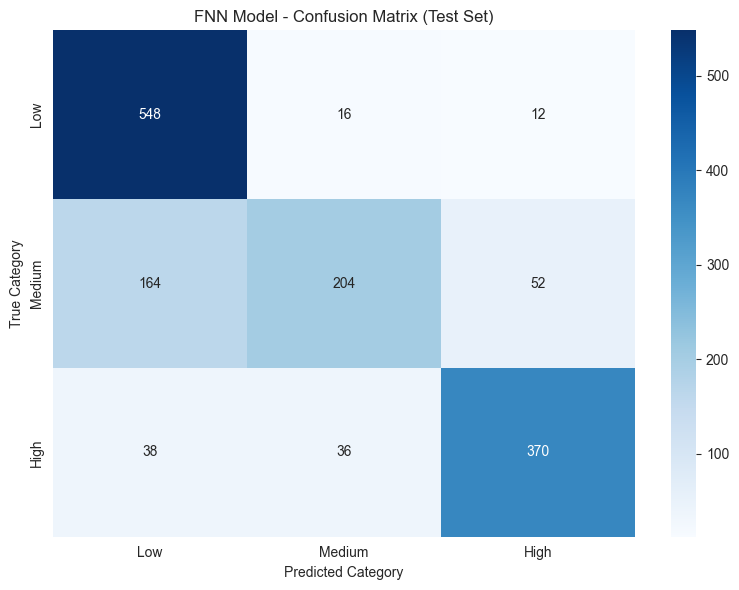


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.73      0.95      0.83       576
      Medium       0.80      0.49      0.60       420
        High       0.85      0.83      0.84       444

    accuracy                           0.78      1440
   macro avg       0.79      0.76      0.76      1440
weighted avg       0.79      0.78      0.77      1440



In [11]:
# Confusion Matrix for FNN
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_fnn_test_cat, y_fnn_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('FNN Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_fnn_test_cat, y_fnn_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

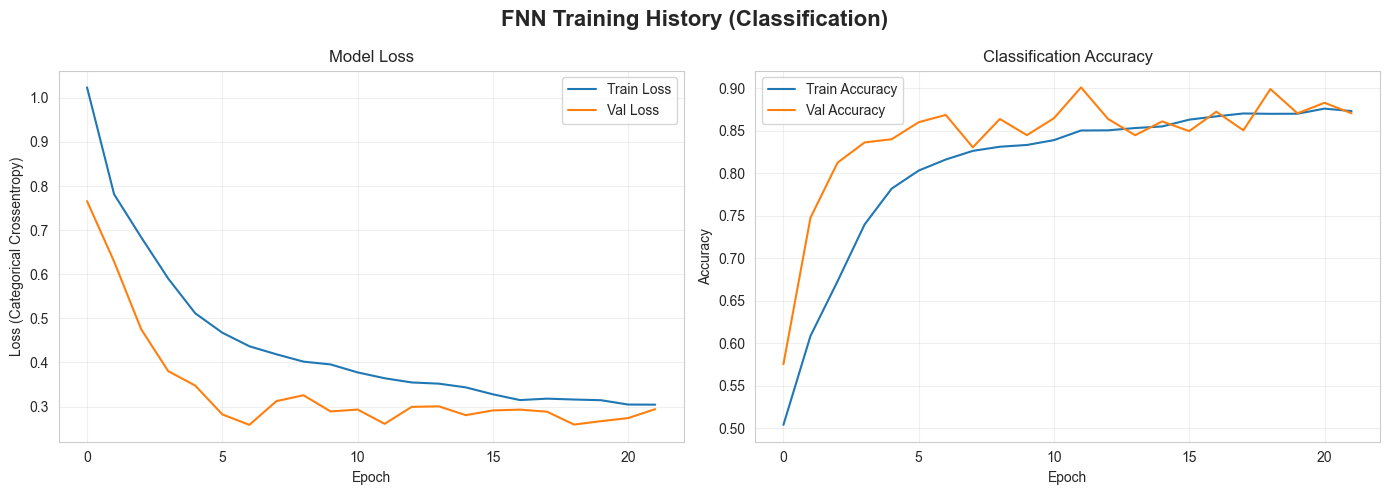

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('FNN Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_fnn.history['loss'], label='Train Loss')
axes[0].plot(history_fnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_fnn.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_fnn.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 2: LSTM (Long Short-Term Memory) Model

### 2.1 Load LSTM Data

### Understanding LSTM (Long Short-Term Memory)

**What is LSTM?**
LSTM is a type of Recurrent Neural Network (RNN) designed to learn from sequential data. It has special "gates" that control what information to remember, forget, or output—making it perfect for time-series patterns.

**Why use LSTM for crop yield prediction?**
- **Temporal patterns**: Agricultural yields depend heavily on *when* weather events occur (e.g., rainfall timing during critical growth stages)
- **Memory of past events**: LSTM can remember conditions from earlier months that affect final yield
- **Sequence learning**: Captures cumulative effects like growing degree days or drought stress over the season

**Our LSTM approach:**
- Input: Monthly sequences (12 months) of climate data, engineered features (GDD, Cumulative Rainfall, Days Into Season), and soil properties
- Architecture: Stacked LSTM layers (128→64) to learn hierarchical temporal patterns
- Target: Annual yield (reconstructed by summing monthly yield allocations)
- **Key insight**: The model learns that early-season rainfall and mid-season temperatures are more critical than late-season conditions

In [13]:
print("\n📊 LOADING LSTM DATA...")

# Load splits
lstm_train = pd.read_csv(splits_path / 'lstm' / 'train.csv')
lstm_val = pd.read_csv(splits_path / 'lstm' / 'val.csv')
lstm_test = pd.read_csv(splits_path / 'lstm' / 'test.csv')

print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in lstm_train.columns:
    lstm_train['Yield_tonnes_per_ha'] = lstm_train['Yield_kg_per_ha'] / 1000
    lstm_val['Yield_tonnes_per_ha'] = lstm_val['Yield_kg_per_ha'] / 1000
    lstm_test['Yield_tonnes_per_ha'] = lstm_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
lstm_train = lstm_train.dropna(subset=['Yield_tonnes_per_ha'])
lstm_val = lstm_val.dropna(subset=['Yield_tonnes_per_ha'])
lstm_test = lstm_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")


📊 LOADING LSTM DATA...


  Train: (115560, 16)
  Val:   (12600, 16)
  Test:  (17280, 16)
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (115560, 17)
  Val:   (12600, 17)
  Test:  (17280, 17)


### 2.2 Prepare LSTM Sequences

In [14]:
# Check available columns
print(f"\nAvailable columns in LSTM data: {list(lstm_train.columns)}")

# Define LSTM feature columns based on what's available
# Climate features
lstm_feature_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'GDD',
    'Cumulative_Rainfall',
    'Days_Into_Season'
]

# Add soil features (monthly averages)
lstm_feature_cols.extend([
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
])

# Filter to only columns that exist
lstm_feature_cols = [col for col in lstm_feature_cols if col in lstm_train.columns]

# Add encoded categorical features
lstm_train['Crop_encoded'] = le_crop.transform(lstm_train['Crop'])
lstm_val['Crop_encoded'] = le_crop.transform(lstm_val['Crop'])
lstm_test['Crop_encoded'] = le_crop.transform(lstm_test['Crop'])

lstm_train['Zone_encoded'] = le_zone.transform(lstm_train['Zone'])
lstm_val['Zone_encoded'] = le_zone.transform(lstm_val['Zone'])
lstm_test['Zone_encoded'] = le_zone.transform(lstm_test['Zone'])

lstm_feature_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\nLSTM features: {len(lstm_feature_cols)}")
print(f"Feature columns: {lstm_feature_cols}")



Available columns in LSTM data: ['Zone', 'Crop', 'Year', 'Month', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Yield_kg_per_ha', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Yield_tonnes_per_ha']

LSTM features: 13
Feature columns: ['Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Crop_encoded', 'Zone_encoded']


In [15]:
def create_sequences(data, feature_cols, target_col, sequence_length=12):
    """
    Create sequences for LSTM
    Each sequence contains 'sequence_length' months of data
    """
    X_sequences = []
    y_sequences = []
    
    # Group by Year, Zone, Crop
    grouped = data.groupby(['Year', 'Zone', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Get features and target
            features = group[feature_cols].values
            
            # Target: Sum all monthly yields (in kg/ha) to get annual yield
            # Then convert to tonnes/ha
            # Monthly yields were divided by 6 across growing season (Apr-Sep)
            # So sum of all months = annual yield in kg/ha
            target = group['Yield_kg_per_ha'].sum() / 1000  # Convert to tonnes/ha
            
            # Create sequence (use first 'sequence_length' months)
            X_sequences.append(features[:sequence_length])
            y_sequences.append(target)
    
    return np.array(X_sequences), np.array(y_sequences)

# Create sequences
print("\nCreating LSTM sequences (12 months)...")
sequence_length = 12

X_lstm_train, y_lstm_train = create_sequences(lstm_train, lstm_feature_cols, target_col, sequence_length)
X_lstm_val, y_lstm_val = create_sequences(lstm_val, lstm_feature_cols, target_col, sequence_length)
X_lstm_test, y_lstm_test = create_sequences(lstm_test, lstm_feature_cols, target_col, sequence_length)

print(f"\nLSTM sequences:")
print(f"  X_train: {X_lstm_train.shape}, y_train: {y_lstm_train.shape}")
print(f"  X_val:   {X_lstm_val.shape}, y_val:   {y_lstm_val.shape}")
print(f"  X_test:  {X_lstm_test.shape}, y_test:  {y_lstm_test.shape}")


Creating LSTM sequences (12 months)...



LSTM sequences:
  X_train: (810, 12, 13), y_train: (810,)
  X_val:   (90, 12, 13), y_val:   (90,)
  X_test:  (120, 12, 13), y_test:  (120,)


In [16]:
# Scale LSTM features
lstm_scaler = StandardScaler()

# Reshape for scaling
n_train, seq_len, n_features = X_lstm_train.shape
X_lstm_train_reshaped = X_lstm_train.reshape(-1, n_features)
X_lstm_train_scaled = lstm_scaler.fit_transform(X_lstm_train_reshaped).reshape(n_train, seq_len, n_features)

n_val = X_lstm_val.shape[0]
X_lstm_val_reshaped = X_lstm_val.reshape(-1, n_features)
X_lstm_val_scaled = lstm_scaler.transform(X_lstm_val_reshaped).reshape(n_val, seq_len, n_features)

n_test = X_lstm_test.shape[0]
X_lstm_test_reshaped = X_lstm_test.reshape(-1, n_features)
X_lstm_test_scaled = lstm_scaler.transform(X_lstm_test_reshaped).reshape(n_test, seq_len, n_features)

print("\n✓ LSTM sequences scaled")


✓ LSTM sequences scaled


### 2.3 Build LSTM Model

### LSTM Model Architecture

**Network Design:**
```
Input (12 timesteps × 13 features)
    ↓
LSTM(128, return_sequences=True) + Dropout(0.3)
    ↓
LSTM(64) + Dropout(0.2)
    ↓
Dense(32) + Dropout(0.1)
    ↓
Output (1 value: annual yield)
```

**Key design decisions:**
- **Stacked LSTMs**: Two layers learn hierarchical temporal patterns
  - Layer 1 (128 units): Learns low-level monthly patterns (rainfall events, temperature fluctuations)
  - Layer 2 (64 units): Learns high-level seasonal patterns (growing season trajectory, cumulative effects)
- **return_sequences=True**: First LSTM outputs full sequence to second LSTM
- **Sequence length**: 12 months (full growing season + off-season context)

**Input features (13 total):**
- Climate: Temperature, Rainfall, Humidity, CO2
- Engineered: GDD, Cumulative_Rainfall, Days_Into_Season
- Soil: pH, Nitrogen, Phosphorus, Organic_Matter
- Categorical: Crop_encoded, Zone_encoded

**Target reconstruction:**
Monthly yields are summed to reconstruct annual yield: `annual_yield = Σ(monthly_yields) / 1000` (convert kg to tonnes)

In [17]:
def build_lstm_model(sequence_length, n_features, learning_rate=0.001):
    """
    Build LSTM model for time-series crop yield CLASSIFICATION.
    
    Architecture rationale:
    - Stacked LSTM layers (reduced: 64 -> 32) to learn both low- and
      high-level temporal patterns from monthly sequences.
    - Dropout and L2 weight decay on LSTM and Dense layers to regularize.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    model = models.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        
        # LSTM layers (reduced capacity + L2 regularization)
        layers.LSTM(64, return_sequences=True,
                     kernel_regularizer=regularizers.l2(1e-4),
                     recurrent_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.4),
        
        layers.LSTM(32, return_sequences=False,
                     kernel_regularizer=regularizers.l2(1e-4),
                     recurrent_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.3),
        
        # Dense layers with L2
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.15),
        
        # Output layer for classification (3 classes)
        layers.Dense(3, activation='softmax')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')],
    )
    
    return model

# Build LSTM model
lstm_model = build_lstm_model(sequence_length=sequence_length, n_features=n_features)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 12, 64)              │          19,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,539 (131.01 KB)

 Trainable params: 33,539 (131.01 KB)

 Non-trainable params: 0 (0.00 B)

### 2.4 Train LSTM Model

In [18]:
# Categorize LSTM targets for classification
print("\n📊 PREPARING LSTM CLASSIFICATION TARGETS...")

# Use same percentiles as FNN for consistency (or calculate from LSTM train data)
y_lstm_train_cat, lstm_percentiles = categorize_yield(y_lstm_train, fnn_percentiles)
y_lstm_val_cat, _ = categorize_yield(y_lstm_val, lstm_percentiles)
y_lstm_test_cat, _ = categorize_yield(y_lstm_test, lstm_percentiles)

print(f"\nClass distribution (LSTM Train):")
unique, counts = np.unique(y_lstm_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_lstm_train_cat)*100:.1f}%)")

# Convert to one-hot encoding
y_lstm_train_onehot = to_categorical(y_lstm_train_cat, num_classes=3)
y_lstm_val_onehot = to_categorical(y_lstm_val_cat, num_classes=3)
y_lstm_test_onehot = to_categorical(y_lstm_test_cat, num_classes=3)

print(f"✓ LSTM targets encoded as one-hot vectors (shape: {y_lstm_train_onehot.shape})")

# Define callbacks
early_stop_lstm = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_lstm = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists for checkpoints
Path('models').mkdir(exist_ok=True)

# Checkpoint to save best weights during training
lstm_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/lstm_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train LSTM model
print("\nTraining LSTM model (Classification)...")
history_lstm = lstm_model.fit(
    X_lstm_train_scaled, y_lstm_train_onehot,
    validation_data=(X_lstm_val_scaled, y_lstm_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_lstm, reduce_lr_lstm, lstm_checkpoint],
    verbose=1,
)

print("\n✓ LSTM model training complete! Best weights saved to models/lstm_best.weights.h5")


📊 PREPARING LSTM CLASSIFICATION TARGETS...

Class distribution (LSTM Train):
  Class 1: 50 samples (6.2%)
  Class 2: 760 samples (93.8%)
✓ LSTM targets encoded as one-hot vectors (shape: (810, 3))

Training LSTM model (Classification)...


Epoch 1/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:10 5s/step - accuracy: 0.4375 - loss: 1.1117 - precision: 0.0000e+00 - recall: 0.0000e+00

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6434 - loss: 1.0167 - precision: 0.5315 - recall: 0.0521         

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7358 - loss: 0.9381 - precision: 0.7540 - recall: 0.1528

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7798 - loss: 0.8686 - precision: 0.8220 - recall: 0.2561


Epoch 1: val_loss improved from None to 0.34219, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.8864 - loss: 0.6217 - precision: 0.9542 - recall: 0.5914 - val_accuracy: 0.9000 - val_loss: 0.3422 - val_precision: 0.9000 - val_recall: 0.9000 - learning_rate: 0.0010


Epoch 2/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9375 - loss: 0.2634 - precision: 0.9375 - recall: 0.9375

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9396 - loss: 0.2779 - precision: 0.9391 - recall: 0.9318 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9428 - loss: 0.2744 - precision: 0.9424 - recall: 0.9358

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9417 - loss: 0.2742 - precision: 0.9413 - recall: 0.9357 

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9406 - loss: 0.2733 - precision: 0.9403 - recall: 0.9354


Epoch 2: val_loss improved from 0.34219 to 0.25726, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9383 - loss: 0.2664 - precision: 0.9381 - recall: 0.9358 - val_accuracy: 0.9000 - val_loss: 0.2573 - val_precision: 0.9000 - val_recall: 0.9000 - learning_rate: 0.0010


Epoch 3/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9375 - loss: 0.1580 - precision: 0.9375 - recall: 0.9375

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9377 - loss: 0.2003 - precision: 0.9368 - recall: 0.9243

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9428 - loss: 0.2021 - precision: 0.9419 - recall: 0.9270

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9427 - loss: 0.2036 - precision: 0.9436 - recall: 0.9270

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9416 - loss: 0.2040 - precision: 0.9442 - recall: 0.9265

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9414 - loss: 0.2034 - precision: 0.9452 - recall: 0.9262


Epoch 3: val_loss improved from 0.25726 to 0.17561, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9420 - loss: 0.2009 - precision: 0.9506 - recall: 0.9259 - val_accuracy: 0.9444 - val_loss: 0.1756 - val_precision: 1.0000 - val_recall: 0.8889 - learning_rate: 0.0010


Epoch 4/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9375 - loss: 0.1115 - precision: 0.9677 - recall: 0.9375

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9452 - loss: 0.1356 - precision: 0.9628 - recall: 0.9377

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9541 - loss: 0.1300 - precision: 0.9682 - recall: 0.9423

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9566 - loss: 0.1296 - precision: 0.9707 - recall: 0.9399

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9579 - loss: 0.1291 - precision: 0.9723 - recall: 0.9379


Epoch 4: val_loss improved from 0.17561 to 0.09398, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9617 - loss: 0.1251 - precision: 0.9742 - recall: 0.9321 - val_accuracy: 1.0000 - val_loss: 0.0940 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 5/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0729 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9865 - loss: 0.0876 - precision: 0.9980 - recall: 0.9731

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9848 - loss: 0.0874 - precision: 0.9966 - recall: 0.9678

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9824 - loss: 0.0896 - precision: 0.9931 - recall: 0.9654

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9803 - loss: 0.0918 - precision: 0.9900 - recall: 0.9632


Epoch 5: val_loss improved from 0.09398 to 0.06715, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9716 - loss: 0.1023 - precision: 0.9773 - recall: 0.9580 - val_accuracy: 1.0000 - val_loss: 0.0672 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 6/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 1.0000 - loss: 0.0527 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.0778 - precision: 0.9834 - recall: 0.9817 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9799 - loss: 0.0884 - precision: 0.9798 - recall: 0.9752

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9779 - loss: 0.0922 - precision: 0.9784 - recall: 0.9719

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9777 - loss: 0.0938 - precision: 0.9784 - recall: 0.9713


Epoch 6: val_loss improved from 0.06715 to 0.05758, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9741 - loss: 0.1033 - precision: 0.9763 - recall: 0.9679 - val_accuracy: 1.0000 - val_loss: 0.0576 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 7/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0480 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9845 - loss: 0.0712 - precision: 0.9845 - recall: 0.9845

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9841 - loss: 0.0743 - precision: 0.9840 - recall: 0.9809

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.0762 - precision: 0.9833 - recall: 0.9784

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9831 - loss: 0.0771 - precision: 0.9832 - recall: 0.9771


Epoch 7: val_loss improved from 0.05758 to 0.04473, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9802 - loss: 0.0850 - precision: 0.9813 - recall: 0.9728 - val_accuracy: 1.0000 - val_loss: 0.0447 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 8/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0380 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.0674 - precision: 0.9815 - recall: 0.9815

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9802 - loss: 0.0716 - precision: 0.9802 - recall: 0.9799

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9802 - loss: 0.0730 - precision: 0.9808 - recall: 0.9794

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9796 - loss: 0.0784 - precision: 0.9804 - recall: 0.9785


Epoch 8: val_loss did not improve from 0.04473


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9753 - loss: 0.0981 - precision: 0.9765 - recall: 0.9741 - val_accuracy: 0.9889 - val_loss: 0.0553 - val_precision: 0.9889 - val_recall: 0.9889 - learning_rate: 0.0010


Epoch 9/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0598 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0809 - precision: 0.9839 - recall: 0.9817 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9780 - loss: 0.0823 - precision: 0.9816 - recall: 0.9780

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9777 - loss: 0.0817 - precision: 0.9814 - recall: 0.9777

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9778 - loss: 0.0813 - precision: 0.9813 - recall: 0.9778


Epoch 9: val_loss improved from 0.04473 to 0.04138, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9778 - loss: 0.0835 - precision: 0.9802 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0414 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 10/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 1.0000 - loss: 0.0346 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9752 - loss: 0.0617 - precision: 0.9774 - recall: 0.9752

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9762 - loss: 0.0647 - precision: 0.9788 - recall: 0.9762

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9776 - loss: 0.0659 - precision: 0.9800 - recall: 0.9776

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9783 - loss: 0.0674 - precision: 0.9805 - recall: 0.9783


Epoch 10: val_loss improved from 0.04138 to 0.03308, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9790 - loss: 0.0752 - precision: 0.9802 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0331 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 11/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0346 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9794 - loss: 0.0636 - precision: 0.9794 - recall: 0.9794 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9761 - loss: 0.0695 - precision: 0.9766 - recall: 0.9761

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9748 - loss: 0.0723 - precision: 0.9764 - recall: 0.9748

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9747 - loss: 0.0740 - precision: 0.9765 - recall: 0.9747


Epoch 11: val_loss did not improve from 0.03308


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9753 - loss: 0.0811 - precision: 0.9777 - recall: 0.9753 - val_accuracy: 1.0000 - val_loss: 0.0340 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 12/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 1.0000 - loss: 0.0419 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9803 - loss: 0.0640 - precision: 0.9803 - recall: 0.9803

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9801 - loss: 0.0641 - precision: 0.9801 - recall: 0.9801

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9807 - loss: 0.0649 - precision: 0.9807 - recall: 0.9807

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9808 - loss: 0.0659 - precision: 0.9808 - recall: 0.9808


Epoch 12: val_loss improved from 0.03308 to 0.02828, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9802 - loss: 0.0703 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0283 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 13/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0412 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9806 - loss: 0.0673 - precision: 0.9806 - recall: 0.9806

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9777 - loss: 0.0706 - precision: 0.9777 - recall: 0.9777

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9779 - loss: 0.0719 - precision: 0.9779 - recall: 0.9779

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9784 - loss: 0.0717 - precision: 0.9784 - recall: 0.9784


Epoch 13: val_loss did not improve from 0.02828


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9815 - loss: 0.0705 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0296 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 14/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0408 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9837 - loss: 0.0646 - precision: 0.9837 - recall: 0.9837 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9836 - loss: 0.0630 - precision: 0.9836 - recall: 0.9836

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.0634 - precision: 0.9826 - recall: 0.9826

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0642 - precision: 0.9823 - recall: 0.9823


Epoch 14: val_loss improved from 0.02828 to 0.02684, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9815 - loss: 0.0684 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0268 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 15/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0277 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9812 - loss: 0.0509 - precision: 0.9812 - recall: 0.9812

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9808 - loss: 0.0559 - precision: 0.9808 - recall: 0.9794 

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9814 - loss: 0.0588 - precision: 0.9814 - recall: 0.9798

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.0607 - precision: 0.9818 - recall: 0.9803


Epoch 15: val_loss improved from 0.02684 to 0.02596, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9827 - loss: 0.0689 - precision: 0.9827 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0260 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 16/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0298 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0567 - precision: 0.9823 - recall: 0.9823 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9841 - loss: 0.0567 - precision: 0.9843 - recall: 0.9841

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.0574 - precision: 0.9850 - recall: 0.9842

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0583 - precision: 0.9852 - recall: 0.9843


Epoch 16: val_loss improved from 0.02596 to 0.02498, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9852 - loss: 0.0644 - precision: 0.9864 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0250 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 17/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0277 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9797 - loss: 0.0570 - precision: 0.9797 - recall: 0.9797 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9780 - loss: 0.0583 - precision: 0.9780 - recall: 0.9780

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9781 - loss: 0.0589 - precision: 0.9781 - recall: 0.9781

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.0598 - precision: 0.9786 - recall: 0.9786


Epoch 17: val_loss did not improve from 0.02498


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9815 - loss: 0.0631 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0254 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 18/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0300 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0589 - precision: 0.9823 - recall: 0.9823

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.0592 - precision: 0.9842 - recall: 0.9842

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9847 - loss: 0.0594 - precision: 0.9847 - recall: 0.9847

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9845 - loss: 0.0603 - precision: 0.9847 - recall: 0.9845


Epoch 18: val_loss improved from 0.02498 to 0.02409, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9827 - loss: 0.0650 - precision: 0.9839 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0241 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 19/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 0.0257 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9789 - loss: 0.0623 - precision: 0.9789 - recall: 0.9789 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9782 - loss: 0.0642 - precision: 0.9782 - recall: 0.9782

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9787 - loss: 0.0637 - precision: 0.9790 - recall: 0.9787

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9793 - loss: 0.0636 - precision: 0.9798 - recall: 0.9793


Epoch 19: val_loss did not improve from 0.02409


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9815 - loss: 0.0639 - precision: 0.9827 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0244 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 20/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0255 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0701 - precision: 0.9817 - recall: 0.9817 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9825 - loss: 0.0678 - precision: 0.9825 - recall: 0.9825

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9832 - loss: 0.0661 - precision: 0.9832 - recall: 0.9829

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9836 - loss: 0.0658 - precision: 0.9836 - recall: 0.9830


Epoch 20: val_loss improved from 0.02409 to 0.02316, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9852 - loss: 0.0649 - precision: 0.9852 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0232 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 21/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0351 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0705 - precision: 0.9817 - recall: 0.9817 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9829 - loss: 0.0668 - precision: 0.9829 - recall: 0.9829

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9837 - loss: 0.0648 - precision: 0.9837 - recall: 0.9837

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.0647 - precision: 0.9839 - recall: 0.9839


Epoch 21: val_loss improved from 0.02316 to 0.02277, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9840 - loss: 0.0673 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0228 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 22/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0349 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9803 - loss: 0.0654 - precision: 0.9803 - recall: 0.9803 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9803 - loss: 0.0630 - precision: 0.9803 - recall: 0.9803

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9809 - loss: 0.0619 - precision: 0.9809 - recall: 0.9809 

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9816 - loss: 0.0612 - precision: 0.9816 - recall: 0.9816


Epoch 22: val_loss improved from 0.02277 to 0.02243, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9840 - loss: 0.0597 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0224 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 23/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0372 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0636 - precision: 0.9817 - recall: 0.9817 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9822 - loss: 0.0608 - precision: 0.9822 - recall: 0.9822

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9829 - loss: 0.0600 - precision: 0.9829 - recall: 0.9829

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.0595 - precision: 0.9834 - recall: 0.9834


Epoch 23: val_loss improved from 0.02243 to 0.02189, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9852 - loss: 0.0577 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0219 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 24/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9688 - loss: 0.0467 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9701 - loss: 0.0732 - precision: 0.9701 - recall: 0.9701 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9749 - loss: 0.0687 - precision: 0.9749 - recall: 0.9749

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9773 - loss: 0.0666 - precision: 0.9773 - recall: 0.9773

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9790 - loss: 0.0653 - precision: 0.9790 - recall: 0.9790


Epoch 24: val_loss improved from 0.02189 to 0.02152, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9840 - loss: 0.0620 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0215 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 25/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0341 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0577 - precision: 0.9823 - recall: 0.9823

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9837 - loss: 0.0563 - precision: 0.9837 - recall: 0.9837

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9839 - loss: 0.0562 - precision: 0.9839 - recall: 0.9839

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9841 - loss: 0.0562 - precision: 0.9841 - recall: 0.9841


Epoch 25: val_loss improved from 0.02152 to 0.02011, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9840 - loss: 0.0572 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0201 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 26/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0352 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9851 - loss: 0.0598 - precision: 0.9851 - recall: 0.9851 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9858 - loss: 0.0581 - precision: 0.9858 - recall: 0.9858

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9860 - loss: 0.0582 - precision: 0.9860 - recall: 0.9860

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9862 - loss: 0.0579 - precision: 0.9862 - recall: 0.9862


Epoch 26: val_loss improved from 0.02011 to 0.01977, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9864 - loss: 0.0569 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0198 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 27/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0397 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0662 - precision: 0.9823 - recall: 0.9823 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9837 - loss: 0.0620 - precision: 0.9837 - recall: 0.9837

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.0614 - precision: 0.9839 - recall: 0.9839

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.0611 - precision: 0.9842 - recall: 0.9842


Epoch 27: val_loss did not improve from 0.01977


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9852 - loss: 0.0609 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0203 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 28/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0383 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9810 - loss: 0.0613 - precision: 0.9810 - recall: 0.9810 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9825 - loss: 0.0578 - precision: 0.9825 - recall: 0.9825

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9838 - loss: 0.0577 - precision: 0.9838 - recall: 0.9838

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0577 - precision: 0.9844 - recall: 0.9844


Epoch 28: val_loss did not improve from 0.01977


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9864 - loss: 0.0571 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0202 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 29/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - loss: 0.0633 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0824 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9766 - loss: 0.0740 - precision: 0.9766 - recall: 0.9766

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9790 - loss: 0.0698 - precision: 0.9790 - recall: 0.9790

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9805 - loss: 0.0673 - precision: 0.9804 - recall: 0.9800


Epoch 29: val_loss improved from 0.01977 to 0.01969, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9852 - loss: 0.0607 - precision: 0.9851 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0197 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 30/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.9688 - loss: 0.0489 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9708 - loss: 0.0752 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9770 - loss: 0.0695 - precision: 0.9770 - recall: 0.9770

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9800 - loss: 0.0667 - precision: 0.9800 - recall: 0.9800

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9813 - loss: 0.0657 - precision: 0.9813 - recall: 0.9813


Epoch 30: val_loss improved from 0.01969 to 0.01941, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9864 - loss: 0.0616 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0194 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 31/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.9688 - loss: 0.0525 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9696 - loss: 0.0742 - precision: 0.9696 - recall: 0.9696 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9753 - loss: 0.0692 - precision: 0.9753 - recall: 0.9753

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9770 - loss: 0.0676 - precision: 0.9770 - recall: 0.9770

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9792 - loss: 0.0654 - precision: 0.9792 - recall: 0.9792

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9803 - loss: 0.0645 - precision: 0.9803 - recall: 0.9803

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9813 - loss: 0.0634 - precision: 0.9813 - recall: 0.9813


Epoch 31: val_loss improved from 0.01941 to 0.01843, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9864 - loss: 0.0570 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0184 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 32/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9688 - loss: 0.0403 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9696 - loss: 0.0633 - precision: 0.9696 - recall: 0.9696

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9751 - loss: 0.0625 - precision: 0.9751 - recall: 0.9751

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9773 - loss: 0.0613 - precision: 0.9773 - recall: 0.9773

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.0609 - precision: 0.9786 - recall: 0.9786

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9796 - loss: 0.0604 - precision: 0.9796 - recall: 0.9796


Epoch 32: val_loss improved from 0.01843 to 0.01830, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9840 - loss: 0.0580 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0183 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 33/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9688 - loss: 0.0438 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9772 - loss: 0.0559 - precision: 0.9772 - recall: 0.9772 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9805 - loss: 0.0548 - precision: 0.9805 - recall: 0.9803

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9824 - loss: 0.0536 - precision: 0.9824 - recall: 0.9816

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9832 - loss: 0.0528 - precision: 0.9832 - recall: 0.9823


Epoch 33: val_loss improved from 0.01830 to 0.01714, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9852 - loss: 0.0537 - precision: 0.9852 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0171 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 34/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9688 - loss: 0.0398 - precision: 1.0000 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9701 - loss: 0.0549 - precision: 0.9816 - recall: 0.9701 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9753 - loss: 0.0521 - precision: 0.9828 - recall: 0.9753

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9786 - loss: 0.0514 - precision: 0.9841 - recall: 0.9786

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9802 - loss: 0.0513 - precision: 0.9848 - recall: 0.9802


Epoch 34: val_loss improved from 0.01714 to 0.01691, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9852 - loss: 0.0529 - precision: 0.9864 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0169 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 35/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.0450 - precision: 0.9688 - recall: 0.9688

 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9703 - loss: 0.0719 - precision: 0.9719 - recall: 0.9703 

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9743 - loss: 0.0676 - precision: 0.9764 - recall: 0.9743

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9763 - loss: 0.0660 - precision: 0.9783 - recall: 0.9763

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9777 - loss: 0.0647 - precision: 0.9796 - recall: 0.9777


Epoch 35: val_loss did not improve from 0.01691


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9827 - loss: 0.0603 - precision: 0.9839 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0170 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 36/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9688 - loss: 0.0578 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9708 - loss: 0.0629 - precision: 0.9708 - recall: 0.9708  

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9770 - loss: 0.0588 - precision: 0.9770 - recall: 0.9770

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9804 - loss: 0.0577 - precision: 0.9804 - recall: 0.9804


Epoch 36: val_loss improved from 0.01691 to 0.01665, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9877 - loss: 0.0554 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0166 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 37/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9688 - loss: 0.0461 - precision: 0.9688 - recall: 0.9688

 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.0701 - precision: 0.9709 - recall: 0.9709 

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9747 - loss: 0.0647 - precision: 0.9747 - recall: 0.9747

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9766 - loss: 0.0623 - precision: 0.9766 - recall: 0.9766

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9779 - loss: 0.0608 - precision: 0.9779 - recall: 0.9779


Epoch 37: val_loss improved from 0.01665 to 0.01635, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9827 - loss: 0.0563 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0163 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 38/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - loss: 0.0567 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0659 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9770 - loss: 0.0596 - precision: 0.9770 - recall: 0.9770

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0572 - precision: 0.9800 - recall: 0.9800

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9816 - loss: 0.0560 - precision: 0.9818 - recall: 0.9816


Epoch 38: val_loss improved from 0.01635 to 0.01614, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9864 - loss: 0.0533 - precision: 0.9876 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0161 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 39/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9688 - loss: 0.0444 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0629 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9770 - loss: 0.0584 - precision: 0.9770 - recall: 0.9770

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0555 - precision: 0.9800 - recall: 0.9800

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9817 - loss: 0.0539 - precision: 0.9817 - recall: 0.9817


Epoch 39: val_loss improved from 0.01614 to 0.01565, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9877 - loss: 0.0480 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0157 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 40/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9688 - loss: 0.0464 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0611 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9764 - loss: 0.0568 - precision: 0.9764 - recall: 0.9764

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9790 - loss: 0.0543 - precision: 0.9790 - recall: 0.9790

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9807 - loss: 0.0531 - precision: 0.9807 - recall: 0.9807


Epoch 40: val_loss improved from 0.01565 to 0.01540, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9864 - loss: 0.0504 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0154 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 41/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - accuracy: 1.0000 - loss: 0.0320 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0518 - precision: 0.9823 - recall: 0.9823 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9847 - loss: 0.0488 - precision: 0.9847 - recall: 0.9847 

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9858 - loss: 0.0486 - precision: 0.9858 - recall: 0.9858

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9866 - loss: 0.0488 - precision: 0.9866 - recall: 0.9866


Epoch 41: val_loss improved from 0.01540 to 0.01516, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9889 - loss: 0.0526 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0152 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 42/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9688 - loss: 0.0569 - precision: 0.9688 - recall: 0.9688

 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9709 - loss: 0.0655 - precision: 0.9709 - recall: 0.9709 

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9765 - loss: 0.0594 - precision: 0.9765 - recall: 0.9765

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9790 - loss: 0.0574 - precision: 0.9790 - recall: 0.9790


Epoch 42: val_loss improved from 0.01516 to 0.01502, saving model to models/lstm_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9864 - loss: 0.0517 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0150 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 43/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0615 - precision: 0.9688 - recall: 0.9688

 8/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9720 - loss: 0.0587 - precision: 0.9720 - recall: 0.9720 

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9777 - loss: 0.0530 - precision: 0.9777 - recall: 0.9777

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9804 - loss: 0.0507 - precision: 0.9804 - recall: 0.9804

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9817 - loss: 0.0495 - precision: 0.9817 - recall: 0.9817


Epoch 43: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9852 - loss: 0.0466 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 0.9667 - val_loss: 0.1409 - val_precision: 0.9667 - val_recall: 0.9667 - learning_rate: 0.0010


Epoch 44/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0455 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9580 - loss: 0.1079 - precision: 0.9580 - recall: 0.9580 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9614 - loss: 0.1002 - precision: 0.9614 - recall: 0.9614

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9645 - loss: 0.0937 - precision: 0.9645 - recall: 0.9645

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9668 - loss: 0.0898 - precision: 0.9668 - recall: 0.9668


Epoch 44: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9753 - loss: 0.0764 - precision: 0.9753 - recall: 0.9753 - val_accuracy: 0.9667 - val_loss: 0.2856 - val_precision: 0.9667 - val_recall: 0.9667 - learning_rate: 0.0010


Epoch 45/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - loss: 0.0472 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9634 - loss: 0.0944 - precision: 0.9634 - recall: 0.9634 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9596 - loss: 0.1074 - precision: 0.9596 - recall: 0.9596

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9544 - loss: 0.1166 - precision: 0.9548 - recall: 0.9542

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9509 - loss: 0.1216 - precision: 0.9521 - recall: 0.9505


Epoch 45: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9407 - loss: 0.1335 - precision: 0.9453 - recall: 0.9395 - val_accuracy: 0.9333 - val_loss: 0.1613 - val_precision: 0.9318 - val_recall: 0.9111 - learning_rate: 0.0010


Epoch 46/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0721 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9631 - loss: 0.0960 - precision: 0.9637 - recall: 0.9631 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9628 - loss: 0.0928 - precision: 0.9645 - recall: 0.9628

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9626 - loss: 0.0922 - precision: 0.9643 - recall: 0.9626

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9618 - loss: 0.0924 - precision: 0.9637 - recall: 0.9618


Epoch 46: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9617 - loss: 0.0903 - precision: 0.9653 - recall: 0.9617 - val_accuracy: 1.0000 - val_loss: 0.0550 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 47/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.9688 - loss: 0.0520 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9672 - loss: 0.0634 - precision: 0.9672 - recall: 0.9672 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9700 - loss: 0.0621 - precision: 0.9700 - recall: 0.9700

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9717 - loss: 0.0617 - precision: 0.9717 - recall: 0.9717

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9730 - loss: 0.0617 - precision: 0.9730 - recall: 0.9730

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9738 - loss: 0.0616 - precision: 0.9738 - recall: 0.9738


Epoch 47: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9802 - loss: 0.0608 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0290 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 48/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0336 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9823 - loss: 0.0509 - precision: 0.9823 - recall: 0.9823

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.0505 - precision: 0.9842 - recall: 0.9842

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9849 - loss: 0.0505 - precision: 0.9849 - recall: 0.9849

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9855 - loss: 0.0506 - precision: 0.9855 - recall: 0.9855


Epoch 48: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9864 - loss: 0.0531 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0222 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 49/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0343 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9746 - loss: 0.0567 - precision: 0.9746 - recall: 0.9746 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9773 - loss: 0.0550 - precision: 0.9773 - recall: 0.9773

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9790 - loss: 0.0541 - precision: 0.9790 - recall: 0.9790

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9804 - loss: 0.0533 - precision: 0.9804 - recall: 0.9804


Epoch 49: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9852 - loss: 0.0503 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0207 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 50/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9688 - loss: 0.0491 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9724 - loss: 0.0669 - precision: 0.9724 - recall: 0.9724 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9775 - loss: 0.0623 - precision: 0.9775 - recall: 0.9775

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9797 - loss: 0.0601 - precision: 0.9797 - recall: 0.9797

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9810 - loss: 0.0590 - precision: 0.9810 - recall: 0.9810


Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 50: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9852 - loss: 0.0566 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0202 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 51/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - loss: 0.0471 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9730 - loss: 0.0712 - precision: 0.9730 - recall: 0.9730 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9797 - loss: 0.0646 - precision: 0.9797 - recall: 0.9797

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9824 - loss: 0.0613 - precision: 0.9824 - recall: 0.9824

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9840 - loss: 0.0593 - precision: 0.9840 - recall: 0.9840


Epoch 51: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9889 - loss: 0.0544 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0205 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 52/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0420 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9701 - loss: 0.0626 - precision: 0.9701 - recall: 0.9701 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9753 - loss: 0.0576 - precision: 0.9753 - recall: 0.9753

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9782 - loss: 0.0560 - precision: 0.9782 - recall: 0.9782

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9798 - loss: 0.0550 - precision: 0.9798 - recall: 0.9798


Epoch 52: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9852 - loss: 0.0511 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0195 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 53/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0333 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0587 - precision: 0.9823 - recall: 0.9823 

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0546 - precision: 0.9844 - recall: 0.9844

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9851 - loss: 0.0539 - precision: 0.9851 - recall: 0.9851

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9857 - loss: 0.0533 - precision: 0.9857 - recall: 0.9857


Epoch 53: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9877 - loss: 0.0527 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0191 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 54/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9688 - loss: 0.0412 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9696 - loss: 0.0587 - precision: 0.9696 - recall: 0.9696

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9737 - loss: 0.0562 - precision: 0.9737 - recall: 0.9737

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9763 - loss: 0.0552 - precision: 0.9763 - recall: 0.9763

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9783 - loss: 0.0549 - precision: 0.9783 - recall: 0.9783


Epoch 54: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9852 - loss: 0.0538 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0201 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 55/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9688 - loss: 0.0475 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9696 - loss: 0.0660 - precision: 0.9696 - recall: 0.9696

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9753 - loss: 0.0622 - precision: 0.9753 - recall: 0.9753

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9781 - loss: 0.0598 - precision: 0.9781 - recall: 0.9781

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9799 - loss: 0.0584 - precision: 0.9799 - recall: 0.9799


Epoch 55: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9852 - loss: 0.0528 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0195 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 56/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9688 - loss: 0.0519 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.0725 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9770 - loss: 0.0676 - precision: 0.9770 - recall: 0.9770

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9800 - loss: 0.0644 - precision: 0.9800 - recall: 0.9800

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9819 - loss: 0.0620 - precision: 0.9819 - recall: 0.9819


Epoch 56: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9877 - loss: 0.0549 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0188 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 57/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9688 - loss: 0.0424 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9708 - loss: 0.0612 - precision: 0.9708 - recall: 0.9708

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9770 - loss: 0.0569 - precision: 0.9770 - recall: 0.9770

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9800 - loss: 0.0550 - precision: 0.9800 - recall: 0.9800

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9819 - loss: 0.0537 - precision: 0.9819 - recall: 0.9819


Epoch 57: val_loss did not improve from 0.01502


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9877 - loss: 0.0509 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0182 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 57: early stopping


Restoring model weights from the end of the best epoch: 42.



✓ LSTM model training complete! Best weights saved to models/lstm_best.weights.h5


### 2.5 Evaluate LSTM Model

In [19]:
# Make predictions
y_lstm_pred_train_probs = lstm_model.predict(X_lstm_train_scaled)
y_lstm_pred_val_probs = lstm_model.predict(X_lstm_val_scaled)
y_lstm_pred_test_probs = lstm_model.predict(X_lstm_test_scaled)

# Convert probabilities to class labels
y_lstm_pred_train = np.argmax(y_lstm_pred_train_probs, axis=1)
y_lstm_pred_val = np.argmax(y_lstm_pred_val_probs, axis=1)
y_lstm_pred_test = np.argmax(y_lstm_pred_test_probs, axis=1)

print("\n" + "="*80)
print("LSTM MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

lstm_metrics_train = calculate_classification_metrics_direct(y_lstm_train_cat, y_lstm_pred_train, "Train")
lstm_metrics_val = calculate_classification_metrics_direct(y_lstm_val_cat, y_lstm_pred_val, "Validation")
lstm_metrics_test = calculate_classification_metrics_direct(y_lstm_test_cat, y_lstm_pred_test, "Test")

 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 403ms/step

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step



LSTM MODEL EVALUATION (CLASSIFICATION)

Train Set - Classification Performance:
  Accuracy:  0.9877
  Precision: 0.9874
  Recall:    0.9877
  F1-Score:  0.9874



Validation Set - Classification Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Test Set - Classification Performance:
  Accuracy:  0.9750
  Precision: 0.9800
  Recall:    0.9750
  F1-Score:  0.9762


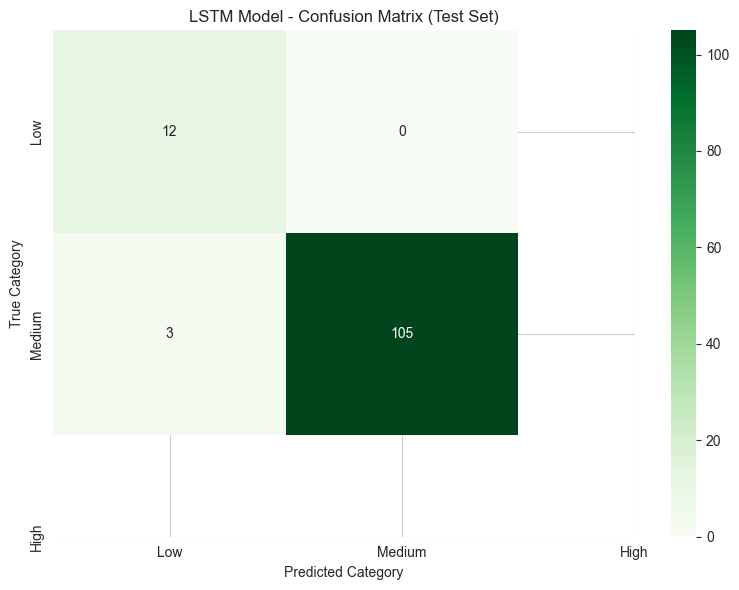


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
      Medium       0.80      1.00      0.89        12
        High       1.00      0.97      0.99       108

    accuracy                           0.97       120
   macro avg       0.60      0.66      0.62       120
weighted avg       0.98      0.97      0.98       120



In [20]:
# Confusion Matrix for LSTM
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_lstm_test_cat, y_lstm_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('LSTM Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_lstm_test_cat, y_lstm_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

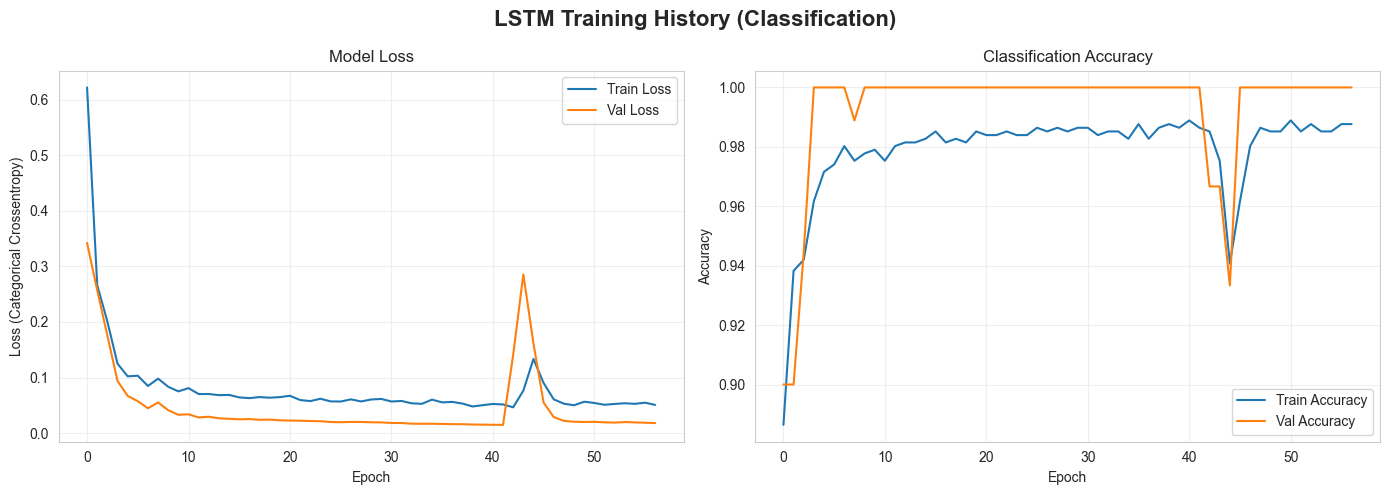

In [21]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('LSTM Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_lstm.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_lstm.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 3: Hybrid Model (LSTM + FNN)

### 3.1 Load Hybrid Data

### Understanding Hybrid Model (LSTM + FNN Combined)

**What is a Hybrid Model?**
A Hybrid model combines the strengths of multiple architectures. Our hybrid merges:
1. **LSTM branch**: Processes temporal climate sequences (what changes month-to-month)
2. **FNN branch**: Processes static features (what stays constant across the season)

**Why is Hybrid expected to perform best?**
1. **Temporal dynamics**: LSTM captures when rainfall arrives, temperature fluctuations, and cumulative effects
2. **Static context**: FNN processes soil fertility (which doesn't change within a season) and crop/zone characteristics
3. **Complementary learning**: Climate patterns interact with soil conditions—the hybrid learns both independently then combines them

**Architecture advantages:**
- LSTM learns: "How does weather evolve over the growing season?"
- FNN learns: "How do soil properties and crop type modify yield potential?"
- Combined: "Given this soil and crop, how does this specific weather pattern affect yield?"

**Expected outcome:**
Hybrid should achieve the highest R² and lowest prediction errors because it leverages:
- Temporal resolution of LSTM (month-by-month patterns)
- Efficiency of FNN for static features (soil, crop, zone)
- Intelligent fusion of both information types

In [22]:
print("\n📊 LOADING HYBRID DATA...")

# Load splits
hybrid_train = pd.read_csv(splits_path / 'hybrid' / 'train.csv')
hybrid_val = pd.read_csv(splits_path / 'hybrid' / 'val.csv')
hybrid_test = pd.read_csv(splits_path / 'hybrid' / 'test.csv')

print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")

# Convert yield to tonnes if in kg
if 'Yield_kg_per_ha' in hybrid_train.columns:
    hybrid_train['Yield_tonnes_per_ha'] = hybrid_train['Yield_kg_per_ha'] / 1000
    hybrid_val['Yield_tonnes_per_ha'] = hybrid_val['Yield_kg_per_ha'] / 1000
    hybrid_test['Yield_tonnes_per_ha'] = hybrid_test['Yield_kg_per_ha'] / 1000
    print("  ✓ Converted yields from kg/ha to tonnes/ha")

# Remove rows with missing yields
hybrid_train = hybrid_train.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_val = hybrid_val.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_test = hybrid_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")


📊 LOADING HYBRID DATA...


  Train: (115560, 16)
  Val:   (12600, 16)
  Test:  (17280, 16)
  ✓ Converted yields from kg/ha to tonnes/ha

After removing missing yields:
  Train: (115560, 17)
  Val:   (12600, 17)
  Test:  (17280, 17)


### 3.2 Prepare Hybrid Features

In [23]:
# Check available columns
print(f"\nAvailable columns in Hybrid data: {list(hybrid_train.columns)}")

# Temporal features (for LSTM branch) - include climate and engineered features
hybrid_temporal_cols = [
    'Temperature_C',
    'Rainfall_mm',
    'Humidity_percent',
    'CO2_ppm',
    'GDD',
    'Cumulative_Rainfall',
    'Days_Into_Season'
]

# Static features (for FNN branch) - soil properties
hybrid_static_cols = [
    'Avg_pH',
    'Avg_Nitrogen_ppm',
    'Avg_Phosphorus_ppm',
    'Avg_Organic_Matter_Percent'
]

# Filter to only columns that exist
hybrid_temporal_cols = [col for col in hybrid_temporal_cols if col in hybrid_train.columns]
hybrid_static_cols = [col for col in hybrid_static_cols if col in hybrid_train.columns]

# Encode categorical
hybrid_train['Crop_encoded'] = le_crop.transform(hybrid_train['Crop'])
hybrid_val['Crop_encoded'] = le_crop.transform(hybrid_val['Crop'])
hybrid_test['Crop_encoded'] = le_crop.transform(hybrid_test['Crop'])

hybrid_train['Zone_encoded'] = le_zone.transform(hybrid_train['Zone'])
hybrid_val['Zone_encoded'] = le_zone.transform(hybrid_val['Zone'])
hybrid_test['Zone_encoded'] = le_zone.transform(hybrid_test['Zone'])

hybrid_static_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\nTemporal features: {len(hybrid_temporal_cols)}")
print(f"Static features: {len(hybrid_static_cols)}")


Available columns in Hybrid data: ['Zone', 'Crop', 'Year', 'Month', 'Temperature_C', 'Rainfall_mm', 'Humidity_percent', 'CO2_ppm', 'Avg_pH', 'Avg_Nitrogen_ppm', 'Avg_Phosphorus_ppm', 'Avg_Organic_Matter_Percent', 'Yield_kg_per_ha', 'GDD', 'Cumulative_Rainfall', 'Days_Into_Season', 'Yield_tonnes_per_ha']

Temporal features: 7
Static features: 6


In [24]:
def create_hybrid_data(data, temporal_cols, static_cols, target_col, sequence_length=12):
    """
    Create hybrid data: temporal sequences + static features
    """
    X_temporal = []
    X_static = []
    y = []
    
    grouped = data.groupby(['Year', 'Zone', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Temporal sequence
            temporal = group[temporal_cols].values[:sequence_length]
            X_temporal.append(temporal)
            
            # Static features (same for all months)
            static = group[static_cols].iloc[0].values
            X_static.append(static)
            
            # Target: Sum all monthly yields (in kg/ha) to get annual yield
            # Then convert to tonnes/ha
            # Monthly yields were divided by 6 across growing season (Apr-Sep)
            # So sum of all months = annual yield in kg/ha
            target = group['Yield_kg_per_ha'].sum() / 1000  # Convert to tonnes/ha
            y.append(target)
    
    return np.array(X_temporal), np.array(X_static), np.array(y)

# Create hybrid datasets
print("\nCreating hybrid datasets...")
X_hybrid_temp_train, X_hybrid_stat_train, y_hybrid_train = create_hybrid_data(
    hybrid_train, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_val, X_hybrid_stat_val, y_hybrid_val = create_hybrid_data(
    hybrid_val, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_test, X_hybrid_stat_test, y_hybrid_test = create_hybrid_data(
    hybrid_test, hybrid_temporal_cols, hybrid_static_cols, target_col
)

print(f"\nHybrid data shapes:")
print(f"  Train - Temporal: {X_hybrid_temp_train.shape}, Static: {X_hybrid_stat_train.shape}")
print(f"  Val   - Temporal: {X_hybrid_temp_val.shape}, Static: {X_hybrid_stat_val.shape}")
print(f"  Test  - Temporal: {X_hybrid_temp_test.shape}, Static: {X_hybrid_stat_test.shape}")


Creating hybrid datasets...



Hybrid data shapes:
  Train - Temporal: (810, 12, 7), Static: (810, 6)
  Val   - Temporal: (90, 12, 7), Static: (90, 6)
  Test  - Temporal: (120, 12, 7), Static: (120, 6)


In [25]:
# Scale temporal features
hybrid_temp_scaler = StandardScaler()
n_train, seq_len, n_temp_features = X_hybrid_temp_train.shape
X_hybrid_temp_train_scaled = hybrid_temp_scaler.fit_transform(
    X_hybrid_temp_train.reshape(-1, n_temp_features)
).reshape(n_train, seq_len, n_temp_features)

n_val = X_hybrid_temp_val.shape[0]
X_hybrid_temp_val_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_val.reshape(-1, n_temp_features)
).reshape(n_val, seq_len, n_temp_features)

n_test = X_hybrid_temp_test.shape[0]
X_hybrid_temp_test_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_test.reshape(-1, n_temp_features)
).reshape(n_test, seq_len, n_temp_features)

# Scale static features
hybrid_stat_scaler = StandardScaler()
X_hybrid_stat_train_scaled = hybrid_stat_scaler.fit_transform(X_hybrid_stat_train)
X_hybrid_stat_val_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_val)
X_hybrid_stat_test_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_test)

print("\n✓ Hybrid features scaled")


✓ Hybrid features scaled


### 3.3 Build Hybrid Model

### Hybrid Model Architecture

**Dual-Branch Design:**

```
TEMPORAL BRANCH (LSTM):                    STATIC BRANCH (FNN):
Input: 12 months × 7 features              Input: 6 features
    ↓                                          ↓
LSTM(64, return_sequences=True)            Dense(32)
    ↓                                          ↓
Dropout(0.3)                               BatchNorm
    ↓                                          ↓
LSTM(32)                                   Dropout(0.2)
    ↓                                          ↓
Dropout(0.2)                               [32 features]
    ↓                                          ↓
[32 features]                                  ↓
    ↓____________merge (concatenate)___________↓
                        ↓
                 Dense(32) + BatchNorm + Dropout(0.1)
                        ↓
                  Output (1 value)
```

**Feature separation rationale:**

**Temporal features** (vary month-to-month):
- Temperature_C, Rainfall_mm, Humidity_percent, CO2_ppm
- GDD, Cumulative_Rainfall, Days_Into_Season
→ Processed by LSTM to capture when events occur

**Static features** (constant across season):
- Soil: Avg_pH, Avg_Nitrogen_ppm, Avg_Phosphorus_ppm, Avg_Organic_Matter_Percent
- Location: Crop_encoded, Zone_encoded
→ Processed by FNN to capture baseline potential

**Fusion strategy:**
The merged layer combines:
- LSTM output: "How weather evolved this season"
- FNN output: "What's the baseline potential for this soil/crop/zone"
- Final Dense layers: "How do these factors interact to determine final yield?"

This architecture leverages the **strengths of both model types** while avoiding their individual weaknesses.

In [26]:
def build_hybrid_model(sequence_length, n_temporal_features, n_static_features, learning_rate=0.001):
    """
    Build Hybrid model combining LSTM (temporal) and FNN (static) branches for CLASSIFICATION.
    
    Architecture rationale:
    - Temporal branch: stacked LSTM layers to extract sequence-level climate signals.
    - Static branch: a small dense network to process soil and categorical features.
    - Merging both branches allows the model to condition temporal dynamics on static context.
    - Output layer with 3 neurons (softmax) for classification into Low/Medium/High yield categories.
    
    Classification setup:
    - Output: Dense(3, activation='softmax') for 3 classes
    - Loss: categorical_crossentropy for multi-class classification
    - Metrics: accuracy, precision, recall for classification performance
    """
    # LSTM branch (temporal)
    temporal_input = layers.Input(shape=(sequence_length, n_temporal_features), name='temporal_input')
    lstm_out = layers.LSTM(64, return_sequences=True,
                           kernel_regularizer=regularizers.l2(1e-4),
                           recurrent_regularizer=regularizers.l2(1e-4))(temporal_input)
    lstm_out = layers.Dropout(0.35)(lstm_out)
    lstm_out = layers.LSTM(32, return_sequences=False,
                           kernel_regularizer=regularizers.l2(1e-4),
                           recurrent_regularizer=regularizers.l2(1e-4))(lstm_out)
    lstm_out = layers.Dropout(0.25)(lstm_out)
    
    # FNN branch (static)
    static_input = layers.Input(shape=(n_static_features,), name='static_input')
    fnn_out = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(static_input)
    fnn_out = layers.BatchNormalization()(fnn_out)
    fnn_out = layers.Dropout(0.25)(fnn_out)
    
    # Merge branches
    merged = layers.concatenate([lstm_out, fnn_out])
    
    # Final layers
    dense_out = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(merged)
    dense_out = layers.BatchNormalization()(dense_out)
    dense_out = layers.Dropout(0.15)(dense_out)
    
    # Output layer for classification (3 classes)
    output = layers.Dense(3, activation='softmax')(dense_out)
    
    # Create model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Build hybrid model
hybrid_model = build_hybrid_model(
    sequence_length=12,
    n_temporal_features=len(hybrid_temporal_cols),
    n_static_features=len(hybrid_static_cols)
)
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ temporal_input (InputLayer)   │ (None, 12, 7)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_2 (LSTM)                 │ (None, 12, 64)            │          18,432 │ temporal_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ static_input (InputLayer)     │ (None, 6)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 12, 64)            │               0 │ lstm_2[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 32)                │             224 │ static_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_3 (LSTM)                 │ (None, 32)                │          12,416 │ dropout_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 32)                │             128 │ dense_6[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 32)                │               0 │ lstm_3[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 32)                │               0 │ batch_normalization_3[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64)                │               0 │ dropout_7[0][0],           │
│                               │                           │                 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 32)                │           2,080 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 32)                │             128 │ dense_7[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 32)                │               0 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 3)                 │              99 │ dropout_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 33,507 (130.89 KB)

 Trainable params: 33,379 (130.39 KB)

 Non-trainable params: 128 (512.00 B)

### 3.4 Train Hybrid Model

In [27]:
# Categorize Hybrid targets for classification
print("\n📊 PREPARING HYBRID CLASSIFICATION TARGETS...")

# Use same percentiles for consistency
y_hybrid_train_cat, hybrid_percentiles = categorize_yield(y_hybrid_train, fnn_percentiles)
y_hybrid_val_cat, _ = categorize_yield(y_hybrid_val, hybrid_percentiles)
y_hybrid_test_cat, _ = categorize_yield(y_hybrid_test, hybrid_percentiles)

print(f"\nClass distribution (Hybrid Train):")
unique, counts = np.unique(y_hybrid_train_cat, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls}: {count} samples ({count/len(y_hybrid_train_cat)*100:.1f}%)")

# Convert to one-hot encoding
y_hybrid_train_onehot = to_categorical(y_hybrid_train_cat, num_classes=3)
y_hybrid_val_onehot = to_categorical(y_hybrid_val_cat, num_classes=3)
y_hybrid_test_onehot = to_categorical(y_hybrid_test_cat, num_classes=3)

print(f"✓ Hybrid targets encoded as one-hot vectors (shape: {y_hybrid_train_onehot.shape})")

# Define callbacks
early_stop_hybrid = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1,
)

reduce_lr_hybrid = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1,
)

# Ensure models directory exists
Path('models').mkdir(exist_ok=True)

# Checkpoint for hybrid
hybrid_checkpoint = callbacks.ModelCheckpoint(
    filepath='models/hybrid_best.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1,
)

# Train hybrid model
print("\nTraining Hybrid model (Classification)...")
history_hybrid = hybrid_model.fit(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled],
    y_hybrid_train_onehot,
    validation_data=([X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled], y_hybrid_val_onehot),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_hybrid, reduce_lr_hybrid, hybrid_checkpoint],
    verbose=1,
)

print("\n✓ Hybrid model training complete! Best weights saved to models/hybrid_best.weights.h5")


📊 PREPARING HYBRID CLASSIFICATION TARGETS...

Class distribution (Hybrid Train):
  Class 1: 50 samples (6.2%)
  Class 2: 760 samples (93.8%)
✓ Hybrid targets encoded as one-hot vectors (shape: (810, 3))

Training Hybrid model (Classification)...


Epoch 1/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 2:13 5s/step - accuracy: 0.3750 - loss: 1.8086 - precision: 0.3571 - recall: 0.3125

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3166 - loss: 1.6478 - precision: 0.3175 - recall: 0.2559 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3168 - loss: 1.5795 - precision: 0.3242 - recall: 0.2528

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3217 - loss: 1.5292 - precision: 0.3350 - recall: 0.2541

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3277 - loss: 1.4935 - precision: 0.3452 - recall: 0.2579


Epoch 1: val_loss improved from None to 0.92653, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.3593 - loss: 1.3646 - precision: 0.3865 - recall: 0.2753 - val_accuracy: 0.7667 - val_loss: 0.9265 - val_precision: 1.0000 - val_recall: 0.0667 - learning_rate: 0.0010


Epoch 2/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6875 - loss: 0.9456 - precision: 0.7619 - recall: 0.5000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5649 - loss: 1.0544 - precision: 0.6098 - recall: 0.4251 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5458 - loss: 1.0689 - precision: 0.6004 - recall: 0.4126

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5436 - loss: 1.0635 - precision: 0.6045 - recall: 0.4104

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5454 - loss: 1.0545 - precision: 0.6092 - recall: 0.4111


Epoch 2: val_loss improved from 0.92653 to 0.74871, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5580 - loss: 1.0196 - precision: 0.6303 - recall: 0.4210 - val_accuracy: 0.9111 - val_loss: 0.7487 - val_precision: 1.0000 - val_recall: 0.5333 - learning_rate: 0.0010


Epoch 3/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6250 - loss: 0.8348 - precision: 0.6522 - recall: 0.4688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6111 - loss: 0.8970 - precision: 0.7057 - recall: 0.4898

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6212 - loss: 0.8928 - precision: 0.7217 - recall: 0.4980 

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6280 - loss: 0.8863 - precision: 0.7261 - recall: 0.5042

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6326 - loss: 0.8800 - precision: 0.7303 - recall: 0.5103


Epoch 3: val_loss improved from 0.74871 to 0.60634, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6519 - loss: 0.8606 - precision: 0.7432 - recall: 0.5358 - val_accuracy: 0.9333 - val_loss: 0.6063 - val_precision: 1.0000 - val_recall: 0.8222 - learning_rate: 0.0010


Epoch 4/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6875 - loss: 0.8366 - precision: 0.7308 - recall: 0.5938

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7056 - loss: 0.8378 - precision: 0.7697 - recall: 0.5882

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7148 - loss: 0.8297 - precision: 0.7848 - recall: 0.5952

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7226 - loss: 0.8161 - precision: 0.7963 - recall: 0.6071

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7291 - loss: 0.8035 - precision: 0.8046 - recall: 0.6151


Epoch 4: val_loss improved from 0.60634 to 0.51288, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7556 - loss: 0.7536 - precision: 0.8312 - recall: 0.6321 - val_accuracy: 0.9444 - val_loss: 0.5129 - val_precision: 1.0000 - val_recall: 0.8667 - learning_rate: 0.0010


Epoch 5/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7812 - loss: 0.6685 - precision: 0.7778 - recall: 0.6562

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7769 - loss: 0.6643 - precision: 0.8241 - recall: 0.6725 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7811 - loss: 0.6680 - precision: 0.8317 - recall: 0.6755

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7894 - loss: 0.6586 - precision: 0.8405 - recall: 0.6857

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7967 - loss: 0.6509 - precision: 0.8474 - recall: 0.6942


Epoch 5: val_loss improved from 0.51288 to 0.42014, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8259 - loss: 0.6174 - precision: 0.8752 - recall: 0.7272 - val_accuracy: 0.9778 - val_loss: 0.4201 - val_precision: 1.0000 - val_recall: 0.9000 - learning_rate: 0.0010


Epoch 6/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8125 - loss: 0.6440 - precision: 0.9565 - recall: 0.6875

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8387 - loss: 0.6324 - precision: 0.9294 - recall: 0.7262

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8475 - loss: 0.6085 - precision: 0.9278 - recall: 0.7462

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8489 - loss: 0.5926 - precision: 0.9263 - recall: 0.7573 

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8518 - loss: 0.5771 - precision: 0.9260 - recall: 0.7665


Epoch 6: val_loss improved from 0.42014 to 0.30481, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8630 - loss: 0.5283 - precision: 0.9241 - recall: 0.7963 - val_accuracy: 1.0000 - val_loss: 0.3048 - val_precision: 1.0000 - val_recall: 0.9556 - learning_rate: 0.0010


Epoch 7/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9375 - loss: 0.3586 - precision: 0.9655 - recall: 0.8750

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9078 - loss: 0.4441 - precision: 0.9487 - recall: 0.8461 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9031 - loss: 0.4572 - precision: 0.9426 - recall: 0.8394

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9025 - loss: 0.4563 - precision: 0.9418 - recall: 0.8377

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9031 - loss: 0.4525 - precision: 0.9421 - recall: 0.8384


Epoch 7: val_loss improved from 0.30481 to 0.26955, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9049 - loss: 0.4368 - precision: 0.9421 - recall: 0.8432 - val_accuracy: 1.0000 - val_loss: 0.2696 - val_precision: 1.0000 - val_recall: 0.9778 - learning_rate: 0.0010


Epoch 8/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9375 - loss: 0.3439 - precision: 1.0000 - recall: 0.8750

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9037 - loss: 0.3815 - precision: 0.9650 - recall: 0.8647 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9082 - loss: 0.3809 - precision: 0.9598 - recall: 0.8690

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9127 - loss: 0.3762 - precision: 0.9592 - recall: 0.8713

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9163 - loss: 0.3718 - precision: 0.9593 - recall: 0.8737


Epoch 8: val_loss improved from 0.26955 to 0.21506, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9296 - loss: 0.3550 - precision: 0.9586 - recall: 0.8864 - val_accuracy: 1.0000 - val_loss: 0.2151 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 9/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.2546 - precision: 1.0000 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9737 - loss: 0.2942 - precision: 0.9800 - recall: 0.9354 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9607 - loss: 0.3039 - precision: 0.9719 - recall: 0.9270

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9543 - loss: 0.3084 - precision: 0.9671 - recall: 0.9215

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9507 - loss: 0.3101 - precision: 0.9646 - recall: 0.9190


Epoch 9: val_loss improved from 0.21506 to 0.17959, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9432 - loss: 0.3050 - precision: 0.9613 - recall: 0.9198 - val_accuracy: 1.0000 - val_loss: 0.1796 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 10/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 218ms/step - accuracy: 0.9688 - loss: 0.2621 - precision: 1.0000 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9494 - loss: 0.2829 - precision: 0.9675 - recall: 0.9456 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9509 - loss: 0.2799 - precision: 0.9662 - recall: 0.9400

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9531 - loss: 0.2736 - precision: 0.9664 - recall: 0.9402

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9530 - loss: 0.2694 - precision: 0.9664 - recall: 0.9390 


Epoch 10: val_loss improved from 0.17959 to 0.15326, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9506 - loss: 0.2560 - precision: 0.9654 - recall: 0.9309 - val_accuracy: 1.0000 - val_loss: 0.1533 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 11/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.2592 - precision: 0.9677 - recall: 0.9375

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9622 - loss: 0.2456 - precision: 0.9628 - recall: 0.9427 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9607 - loss: 0.2409 - precision: 0.9620 - recall: 0.9399

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9621 - loss: 0.2346 - precision: 0.9636 - recall: 0.9419

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9619 - loss: 0.2319 - precision: 0.9644 - recall: 0.9423


Epoch 11: val_loss improved from 0.15326 to 0.12978, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9593 - loss: 0.2252 - precision: 0.9670 - recall: 0.9420 - val_accuracy: 1.0000 - val_loss: 0.1298 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 12/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.1873 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9597 - loss: 0.2229 - precision: 0.9652 - recall: 0.9449 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9617 - loss: 0.2168 - precision: 0.9686 - recall: 0.9470

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9618 - loss: 0.2129 - precision: 0.9686 - recall: 0.9481

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9614 - loss: 0.2104 - precision: 0.9681 - recall: 0.9483


Epoch 12: val_loss improved from 0.12978 to 0.10803, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9605 - loss: 0.2061 - precision: 0.9660 - recall: 0.9481 - val_accuracy: 1.0000 - val_loss: 0.1080 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 13/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 1.0000 - loss: 0.1124 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9729 - loss: 0.1845 - precision: 0.9772 - recall: 0.9567 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9668 - loss: 0.1852 - precision: 0.9719 - recall: 0.9516

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9638 - loss: 0.1850 - precision: 0.9692 - recall: 0.9499

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9631 - loss: 0.1832 - precision: 0.9687 - recall: 0.9501


Epoch 13: val_loss improved from 0.10803 to 0.09312, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9617 - loss: 0.1751 - precision: 0.9698 - recall: 0.9531 - val_accuracy: 1.0000 - val_loss: 0.0931 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 14/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.1122 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9578 - loss: 0.1720 - precision: 0.9670 - recall: 0.9564 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9564 - loss: 0.1729 - precision: 0.9654 - recall: 0.9531

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9549 - loss: 0.1760 - precision: 0.9627 - recall: 0.9514

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9542 - loss: 0.1779 - precision: 0.9611 - recall: 0.9504


Epoch 14: val_loss improved from 0.09312 to 0.08799, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9531 - loss: 0.1811 - precision: 0.9576 - recall: 0.9481 - val_accuracy: 1.0000 - val_loss: 0.0880 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 15/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.1118 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9403 - loss: 0.2006 - precision: 0.9516 - recall: 0.9389 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9479 - loss: 0.1841 - precision: 0.9575 - recall: 0.9457

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9510 - loss: 0.1778 - precision: 0.9594 - recall: 0.9485

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9528 - loss: 0.1747 - precision: 0.9603 - recall: 0.9495


Epoch 15: val_loss improved from 0.08799 to 0.07792, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9580 - loss: 0.1629 - precision: 0.9614 - recall: 0.9531 - val_accuracy: 1.0000 - val_loss: 0.0779 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 16/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9688 - loss: 0.1616 - precision: 0.9677 - recall: 0.9375

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9701 - loss: 0.1572 - precision: 0.9745 - recall: 0.9556

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9729 - loss: 0.1474 - precision: 0.9765 - recall: 0.9596 

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9749 - loss: 0.1407 - precision: 0.9785 - recall: 0.9628

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9748 - loss: 0.1396 - precision: 0.9784 - recall: 0.9639


Epoch 16: val_loss improved from 0.07792 to 0.06668, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9753 - loss: 0.1325 - precision: 0.9788 - recall: 0.9691 - val_accuracy: 1.0000 - val_loss: 0.0667 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 17/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 283ms/step - accuracy: 1.0000 - loss: 0.1245 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9748 - loss: 0.1594 - precision: 0.9746 - recall: 0.9673 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9714 - loss: 0.1531 - precision: 0.9712 - recall: 0.9652

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9704 - loss: 0.1499 - precision: 0.9702 - recall: 0.9646

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9687 - loss: 0.1488 - precision: 0.9685 - recall: 0.9636


Epoch 17: val_loss improved from 0.06668 to 0.06200, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9617 - loss: 0.1452 - precision: 0.9628 - recall: 0.9593 - val_accuracy: 1.0000 - val_loss: 0.0620 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 18/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0881 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9726 - loss: 0.1153 - precision: 0.9748 - recall: 0.9726 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9728 - loss: 0.1213 - precision: 0.9753 - recall: 0.9719

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9731 - loss: 0.1235 - precision: 0.9754 - recall: 0.9719

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9734 - loss: 0.1248 - precision: 0.9755 - recall: 0.9722


Epoch 18: val_loss improved from 0.06200 to 0.05577, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9741 - loss: 0.1280 - precision: 0.9752 - recall: 0.9728 - val_accuracy: 1.0000 - val_loss: 0.0558 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 19/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0696 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9737 - loss: 0.1150 - precision: 0.9807 - recall: 0.9737 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9734 - loss: 0.1153 - precision: 0.9785 - recall: 0.9720

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9732 - loss: 0.1144 - precision: 0.9772 - recall: 0.9711

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9728 - loss: 0.1145 - precision: 0.9762 - recall: 0.9703


Epoch 19: val_loss improved from 0.05577 to 0.05020, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9704 - loss: 0.1144 - precision: 0.9715 - recall: 0.9667 - val_accuracy: 1.0000 - val_loss: 0.0502 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 20/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0533 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9782 - loss: 0.1096 - precision: 0.9782 - recall: 0.9782 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9751 - loss: 0.1109 - precision: 0.9765 - recall: 0.9751

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9739 - loss: 0.1124 - precision: 0.9754 - recall: 0.9739

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9730 - loss: 0.1140 - precision: 0.9744 - recall: 0.9727


Epoch 20: val_loss improved from 0.05020 to 0.04841, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9716 - loss: 0.1173 - precision: 0.9728 - recall: 0.9704 - val_accuracy: 1.0000 - val_loss: 0.0484 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 21/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 1.0000 - loss: 0.0583 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9815 - loss: 0.0844 - precision: 0.9815 - recall: 0.9815 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9802 - loss: 0.0836 - precision: 0.9802 - recall: 0.9802

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9809 - loss: 0.0843 - precision: 0.9809 - recall: 0.9804

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9807 - loss: 0.0866 - precision: 0.9807 - recall: 0.9796


Epoch 21: val_loss improved from 0.04841 to 0.04101, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9815 - loss: 0.0897 - precision: 0.9814 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0410 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 22/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0415 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9704 - loss: 0.1018 - precision: 0.9704 - recall: 0.9704 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9706 - loss: 0.0997 - precision: 0.9706 - recall: 0.9706

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9706 - loss: 0.0980 - precision: 0.9706 - recall: 0.9706

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9698 - loss: 0.0993 - precision: 0.9698 - recall: 0.9698


Epoch 22: val_loss improved from 0.04101 to 0.03767, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9691 - loss: 0.1026 - precision: 0.9691 - recall: 0.9691 - val_accuracy: 1.0000 - val_loss: 0.0377 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 23/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0810 - precision: 1.0000 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.1083 - precision: 0.9802 - recall: 0.9658

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9757 - loss: 0.1002 - precision: 0.9782 - recall: 0.9676

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9733 - loss: 0.0980 - precision: 0.9755 - recall: 0.9671

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9726 - loss: 0.0980 - precision: 0.9746 - recall: 0.9672


Epoch 23: val_loss improved from 0.03767 to 0.03751, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9716 - loss: 0.0968 - precision: 0.9727 - recall: 0.9691 - val_accuracy: 1.0000 - val_loss: 0.0375 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 24/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9688 - loss: 0.0756 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9688 - loss: 0.1185 - precision: 0.9710 - recall: 0.9688 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9721 - loss: 0.1076 - precision: 0.9747 - recall: 0.9721

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9735 - loss: 0.1028 - precision: 0.9759 - recall: 0.9735

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9741 - loss: 0.1008 - precision: 0.9762 - recall: 0.9741


Epoch 24: val_loss improved from 0.03751 to 0.03289, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9765 - loss: 0.0947 - precision: 0.9778 - recall: 0.9765 - val_accuracy: 1.0000 - val_loss: 0.0329 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 25/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9688 - loss: 0.0962 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9708 - loss: 0.1153 - precision: 0.9708 - recall: 0.9708 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9736 - loss: 0.1122 - precision: 0.9736 - recall: 0.9725

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9742 - loss: 0.1125 - precision: 0.9741 - recall: 0.9728

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9744 - loss: 0.1117 - precision: 0.9743 - recall: 0.9730


Epoch 25: val_loss did not improve from 0.03289


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9753 - loss: 0.1066 - precision: 0.9753 - recall: 0.9741 - val_accuracy: 1.0000 - val_loss: 0.0332 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 26/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0373 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.0852 - precision: 0.9834 - recall: 0.9815

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9786 - loss: 0.0874 - precision: 0.9812 - recall: 0.9786

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0849 - precision: 0.9827 - recall: 0.9802

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9806 - loss: 0.0850 - precision: 0.9828 - recall: 0.9804

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0852 - precision: 0.9823 - recall: 0.9799


Epoch 26: val_loss improved from 0.03289 to 0.03011, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9790 - loss: 0.0865 - precision: 0.9802 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0301 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 27/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0569 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9772 - loss: 0.1011 - precision: 0.9790 - recall: 0.9772

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9770 - loss: 0.0973 - precision: 0.9796 - recall: 0.9770

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9782 - loss: 0.0920 - precision: 0.9806 - recall: 0.9782

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9779 - loss: 0.0906 - precision: 0.9801 - recall: 0.9779


Epoch 27: val_loss improved from 0.03011 to 0.02936, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9790 - loss: 0.0808 - precision: 0.9802 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0294 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 28/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9688 - loss: 0.0737 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9696 - loss: 0.1196 - precision: 0.9696 - recall: 0.9696

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9753 - loss: 0.1077 - precision: 0.9753 - recall: 0.9746

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9778 - loss: 0.1025 - precision: 0.9778 - recall: 0.9767

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9788 - loss: 0.1004 - precision: 0.9787 - recall: 0.9775


Epoch 28: val_loss improved from 0.02936 to 0.02847, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9802 - loss: 0.0909 - precision: 0.9802 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0285 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 29/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0350 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9828 - loss: 0.0815 - precision: 0.9828 - recall: 0.9828 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9821 - loss: 0.0840 - precision: 0.9821 - recall: 0.9821

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9802 - loss: 0.0890 - precision: 0.9802 - recall: 0.9802

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9788 - loss: 0.0934 - precision: 0.9788 - recall: 0.9788


Epoch 29: val_loss did not improve from 0.02847


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9728 - loss: 0.1092 - precision: 0.9728 - recall: 0.9728 - val_accuracy: 1.0000 - val_loss: 0.0300 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 30/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0396 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9785 - loss: 0.0877 - precision: 0.9784 - recall: 0.9778 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9765 - loss: 0.0879 - precision: 0.9764 - recall: 0.9748

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9740 - loss: 0.0904 - precision: 0.9740 - recall: 0.9722

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9734 - loss: 0.0914 - precision: 0.9734 - recall: 0.9717


Epoch 30: val_loss improved from 0.02847 to 0.02664, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9728 - loss: 0.0956 - precision: 0.9728 - recall: 0.9716 - val_accuracy: 1.0000 - val_loss: 0.0266 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 31/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9688 - loss: 0.0815 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9581 - loss: 0.1276 - precision: 0.9581 - recall: 0.9581 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9638 - loss: 0.1188 - precision: 0.9645 - recall: 0.9638

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9656 - loss: 0.1134 - precision: 0.9668 - recall: 0.9656

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9669 - loss: 0.1093 - precision: 0.9681 - recall: 0.9668


Epoch 31: val_loss did not improve from 0.02664


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9728 - loss: 0.0918 - precision: 0.9740 - recall: 0.9716 - val_accuracy: 1.0000 - val_loss: 0.0282 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 32/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 299ms/step - accuracy: 0.9688 - loss: 0.0795 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9727 - loss: 0.0769 - precision: 0.9727 - recall: 0.9727 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9738 - loss: 0.0752 - precision: 0.9738 - recall: 0.9738

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9762 - loss: 0.0721 - precision: 0.9762 - recall: 0.9762

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9764 - loss: 0.0736 - precision: 0.9764 - recall: 0.9761


Epoch 32: val_loss improved from 0.02664 to 0.02284, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9765 - loss: 0.0822 - precision: 0.9765 - recall: 0.9753 - val_accuracy: 1.0000 - val_loss: 0.0228 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 33/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 6s 274ms/step - accuracy: 1.0000 - loss: 0.0378 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9663 - loss: 0.0907 - precision: 0.9716 - recall: 0.9649  

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9671 - loss: 0.0915 - precision: 0.9727 - recall: 0.9649

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9657 - loss: 0.0933 - precision: 0.9710 - recall: 0.9636

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9644 - loss: 0.0942 - precision: 0.9694 - recall: 0.9624


Epoch 33: val_loss did not improve from 0.02284


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9630 - loss: 0.0919 - precision: 0.9665 - recall: 0.9617 - val_accuracy: 1.0000 - val_loss: 0.0238 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 34/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0378 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9803 - loss: 0.0999 - precision: 0.9803 - recall: 0.9803

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9813 - loss: 0.0941 - precision: 0.9813 - recall: 0.9813

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9805 - loss: 0.0932 - precision: 0.9805 - recall: 0.9804

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9794 - loss: 0.0943 - precision: 0.9794 - recall: 0.9790


Epoch 34: val_loss improved from 0.02284 to 0.02263, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9765 - loss: 0.0948 - precision: 0.9765 - recall: 0.9753 - val_accuracy: 1.0000 - val_loss: 0.0226 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 35/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 1.0000 - loss: 0.0427 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9828 - loss: 0.0767 - precision: 0.9828 - recall: 0.9828

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9776 - loss: 0.0845 - precision: 0.9776 - recall: 0.9776

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9770 - loss: 0.0835 - precision: 0.9770 - recall: 0.9770

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9768 - loss: 0.0821 - precision: 0.9768 - recall: 0.9764


Epoch 35: val_loss improved from 0.02263 to 0.02096, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9765 - loss: 0.0757 - precision: 0.9765 - recall: 0.9753 - val_accuracy: 1.0000 - val_loss: 0.0210 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 36/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 1.0000 - loss: 0.0262 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9824 - loss: 0.0781 - precision: 0.9824 - recall: 0.9824

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9842 - loss: 0.0752 - precision: 0.9842 - recall: 0.9842

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9848 - loss: 0.0739 - precision: 0.9848 - recall: 0.9848

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9847 - loss: 0.0741 - precision: 0.9847 - recall: 0.9847


Epoch 36: val_loss improved from 0.02096 to 0.02062, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9852 - loss: 0.0728 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0206 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 37/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 1.0000 - loss: 0.0250 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9843 - loss: 0.0562 - precision: 0.9843 - recall: 0.9843 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9853 - loss: 0.0564 - precision: 0.9853 - recall: 0.9853

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9845 - loss: 0.0568 - precision: 0.9845 - recall: 0.9845

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9833 - loss: 0.0593 - precision: 0.9833 - recall: 0.9833


Epoch 37: val_loss improved from 0.02062 to 0.02025, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9790 - loss: 0.0693 - precision: 0.9790 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0202 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 38/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9688 - loss: 0.0743 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9695 - loss: 0.0818 - precision: 0.9695 - recall: 0.9695 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9733 - loss: 0.0766 - precision: 0.9733 - recall: 0.9733

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9744 - loss: 0.0744 - precision: 0.9744 - recall: 0.9744

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9752 - loss: 0.0733 - precision: 0.9752 - recall: 0.9752


Epoch 38: val_loss improved from 0.02025 to 0.01997, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9790 - loss: 0.0706 - precision: 0.9790 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0200 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 39/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.0321 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.0545 - precision: 0.9866 - recall: 0.9866

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.0548 - precision: 0.9866 - recall: 0.9866

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9860 - loss: 0.0551 - precision: 0.9860 - recall: 0.9860

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9850 - loss: 0.0559 - precision: 0.9850 - recall: 0.9850


Epoch 39: val_loss improved from 0.01997 to 0.01940, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9827 - loss: 0.0643 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0194 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 40/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0423 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9840 - loss: 0.0823 - precision: 0.9846 - recall: 0.9840 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0749 - precision: 0.9862 - recall: 0.9844

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9845 - loss: 0.0727 - precision: 0.9863 - recall: 0.9845

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9842 - loss: 0.0719 - precision: 0.9860 - recall: 0.9842


Epoch 40: val_loss improved from 0.01940 to 0.01926, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9827 - loss: 0.0676 - precision: 0.9851 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0193 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 41/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 1.0000 - loss: 0.0251 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9810 - loss: 0.0851 - precision: 0.9810 - recall: 0.9810 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9812 - loss: 0.0813 - precision: 0.9812 - recall: 0.9812

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9815 - loss: 0.0804 - precision: 0.9815 - recall: 0.9815

22/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9815 - loss: 0.0815 - precision: 0.9815 - recall: 0.9815


Epoch 41: val_loss improved from 0.01926 to 0.01869, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9815 - loss: 0.0818 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0187 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 42/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9688 - loss: 0.0616 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9715 - loss: 0.0977 - precision: 0.9715 - recall: 0.9715

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9752 - loss: 0.0888 - precision: 0.9752 - recall: 0.9752

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9779 - loss: 0.0820 - precision: 0.9779 - recall: 0.9779

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0816 - precision: 0.9788 - recall: 0.9788

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9793 - loss: 0.0818 - precision: 0.9793 - recall: 0.9793


Epoch 42: val_loss improved from 0.01869 to 0.01836, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9815 - loss: 0.0825 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0184 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 43/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0312 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9812 - loss: 0.0750 - precision: 0.9812 - recall: 0.9812 

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9820 - loss: 0.0723 - precision: 0.9820 - recall: 0.9820

17/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.0715 - precision: 0.9826 - recall: 0.9826

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9825 - loss: 0.0727 - precision: 0.9825 - recall: 0.9822


Epoch 43: val_loss improved from 0.01836 to 0.01835, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9840 - loss: 0.0724 - precision: 0.9839 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0184 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 44/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9688 - loss: 0.0916 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9735 - loss: 0.1014 - precision: 0.9735 - recall: 0.9735

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9781 - loss: 0.0859 - precision: 0.9781 - recall: 0.9781

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9790 - loss: 0.0803 - precision: 0.9790 - recall: 0.9790

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9785 - loss: 0.0774 - precision: 0.9785 - recall: 0.9785


Epoch 44: val_loss did not improve from 0.01835


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9778 - loss: 0.0677 - precision: 0.9778 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0196 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 45/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9688 - loss: 0.0885 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9671 - loss: 0.0827 - precision: 0.9671 - recall: 0.9671

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9718 - loss: 0.0749 - precision: 0.9718 - recall: 0.9718

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9745 - loss: 0.0726 - precision: 0.9745 - recall: 0.9745

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9757 - loss: 0.0725 - precision: 0.9757 - recall: 0.9757


Epoch 45: val_loss did not improve from 0.01835


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9802 - loss: 0.0704 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0185 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 46/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9688 - loss: 0.0444 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9637 - loss: 0.0881 - precision: 0.9637 - recall: 0.9637

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9691 - loss: 0.0802 - precision: 0.9691 - recall: 0.9691

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9717 - loss: 0.0766 - precision: 0.9717 - recall: 0.9717

23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9731 - loss: 0.0758 - precision: 0.9730 - recall: 0.9727


Epoch 46: val_loss improved from 0.01835 to 0.01762, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9790 - loss: 0.0690 - precision: 0.9790 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0176 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 47/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 1.0000 - loss: 0.0529 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9805 - loss: 0.1001 - precision: 0.9805 - recall: 0.9805 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0951 - precision: 0.9788 - recall: 0.9788

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9791 - loss: 0.0881 - precision: 0.9791 - recall: 0.9791

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9797 - loss: 0.0849 - precision: 0.9797 - recall: 0.9796

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9808 - loss: 0.0816 - precision: 0.9808 - recall: 0.9804


Epoch 47: val_loss improved from 0.01762 to 0.01708, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9852 - loss: 0.0669 - precision: 0.9852 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0171 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 48/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.9688 - loss: 0.0740 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9602 - loss: 0.0869 - precision: 0.9602 - recall: 0.9602

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9653 - loss: 0.0797 - precision: 0.9653 - recall: 0.9653

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9679 - loss: 0.0743 - precision: 0.9679 - recall: 0.9679

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9693 - loss: 0.0722 - precision: 0.9693 - recall: 0.9693

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9704 - loss: 0.0711 - precision: 0.9704 - recall: 0.9704


Epoch 48: val_loss did not improve from 0.01708


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9753 - loss: 0.0664 - precision: 0.9753 - recall: 0.9753 - val_accuracy: 1.0000 - val_loss: 0.0177 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 49/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0355 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9837 - loss: 0.0779 - precision: 0.9837 - recall: 0.9837

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9814 - loss: 0.0748 - precision: 0.9814 - recall: 0.9814

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9811 - loss: 0.0707 - precision: 0.9811 - recall: 0.9811

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9801 - loss: 0.0691 - precision: 0.9801 - recall: 0.9801

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9796 - loss: 0.0683 - precision: 0.9796 - recall: 0.9796


Epoch 49: val_loss did not improve from 0.01708


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9778 - loss: 0.0658 - precision: 0.9778 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0175 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 50/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0357 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9843 - loss: 0.0783 - precision: 0.9843 - recall: 0.9843

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9850 - loss: 0.0697 - precision: 0.9850 - recall: 0.9850

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9856 - loss: 0.0647 - precision: 0.9856 - recall: 0.9856

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9849 - loss: 0.0650 - precision: 0.9849 - recall: 0.9849

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9843 - loss: 0.0656 - precision: 0.9843 - recall: 0.9843


Epoch 50: val_loss did not improve from 0.01708


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9815 - loss: 0.0678 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0175 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 51/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9688 - loss: 0.0659 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9701 - loss: 0.0991 - precision: 0.9709 - recall: 0.9701

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9723 - loss: 0.0917 - precision: 0.9744 - recall: 0.9723

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9746 - loss: 0.0852 - precision: 0.9767 - recall: 0.9746

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9753 - loss: 0.0827 - precision: 0.9773 - recall: 0.9753

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9757 - loss: 0.0809 - precision: 0.9775 - recall: 0.9757


Epoch 51: val_loss improved from 0.01708 to 0.01593, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9778 - loss: 0.0726 - precision: 0.9790 - recall: 0.9778 - val_accuracy: 1.0000 - val_loss: 0.0159 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 52/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 1.0000 - loss: 0.0493 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9866 - loss: 0.0758 - precision: 0.9866 - recall: 0.9866

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9870 - loss: 0.0677 - precision: 0.9878 - recall: 0.9870

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9856 - loss: 0.0640 - precision: 0.9869 - recall: 0.9856

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9850 - loss: 0.0638 - precision: 0.9863 - recall: 0.9850

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9847 - loss: 0.0635 - precision: 0.9861 - recall: 0.9845


Epoch 52: val_loss did not improve from 0.01593


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9840 - loss: 0.0625 - precision: 0.9851 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0166 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 53/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9688 - loss: 0.0794 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9727 - loss: 0.0711 - precision: 0.9727 - recall: 0.9727

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9751 - loss: 0.0675 - precision: 0.9751 - recall: 0.9751

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9768 - loss: 0.0646 - precision: 0.9768 - recall: 0.9768

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9774 - loss: 0.0650 - precision: 0.9774 - recall: 0.9774

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9783 - loss: 0.0646 - precision: 0.9783 - recall: 0.9783


Epoch 53: val_loss did not improve from 0.01593


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9815 - loss: 0.0626 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0161 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 54/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0192 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9843 - loss: 0.0613 - precision: 0.9843 - recall: 0.9843

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9863 - loss: 0.0578 - precision: 0.9863 - recall: 0.9863

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9877 - loss: 0.0551 - precision: 0.9877 - recall: 0.9877

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9877 - loss: 0.0565 - precision: 0.9877 - recall: 0.9877

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9879 - loss: 0.0567 - precision: 0.9879 - recall: 0.9879


Epoch 54: val_loss did not improve from 0.01593


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9889 - loss: 0.0578 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0163 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 55/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 1.0000 - loss: 0.0432 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0610 - precision: 0.9824 - recall: 0.9824

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9814 - loss: 0.0593 - precision: 0.9814 - recall: 0.9814

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9823 - loss: 0.0562 - precision: 0.9823 - recall: 0.9823

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9826 - loss: 0.0559 - precision: 0.9826 - recall: 0.9826

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9827 - loss: 0.0557 - precision: 0.9827 - recall: 0.9827


Epoch 55: val_loss did not improve from 0.01593


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9827 - loss: 0.0569 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0165 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 56/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 1.0000 - loss: 0.0189 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0568 - precision: 0.9824 - recall: 0.9824

10/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9834 - loss: 0.0574 - precision: 0.9834 - recall: 0.9834

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.0565 - precision: 0.9840 - recall: 0.9840

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9836 - loss: 0.0579 - precision: 0.9836 - recall: 0.9836

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9831 - loss: 0.0592 - precision: 0.9831 - recall: 0.9831


Epoch 56: val_loss did not improve from 0.01593


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9815 - loss: 0.0677 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0161 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 57/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 1.0000 - loss: 0.0344 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0911 - precision: 0.9824 - recall: 0.9824 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9839 - loss: 0.0805 - precision: 0.9839 - recall: 0.9839

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9855 - loss: 0.0735 - precision: 0.9855 - recall: 0.9855

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9855 - loss: 0.0716 - precision: 0.9855 - recall: 0.9855

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9854 - loss: 0.0699 - precision: 0.9854 - recall: 0.9854


Epoch 57: val_loss improved from 0.01593 to 0.01538, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9852 - loss: 0.0615 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0154 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 58/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 0.0279 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9892 - loss: 0.0593 - precision: 0.9892 - recall: 0.9892 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9909 - loss: 0.0549 - precision: 0.9909 - recall: 0.9909

15/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9906 - loss: 0.0542 - precision: 0.9906 - recall: 0.9906

20/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9896 - loss: 0.0548 - precision: 0.9896 - recall: 0.9896

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9889 - loss: 0.0550 - precision: 0.9889 - recall: 0.9889


Epoch 58: val_loss improved from 0.01538 to 0.01524, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9864 - loss: 0.0549 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0152 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 59/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9688 - loss: 0.0475 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9696 - loss: 0.0643 - precision: 0.9696 - recall: 0.9696

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9751 - loss: 0.0613 - precision: 0.9751 - recall: 0.9751

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9780 - loss: 0.0586 - precision: 0.9780 - recall: 0.9780

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9785 - loss: 0.0589 - precision: 0.9785 - recall: 0.9785

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9785 - loss: 0.0592 - precision: 0.9787 - recall: 0.9785


Epoch 59: val_loss improved from 0.01524 to 0.01449, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9790 - loss: 0.0593 - precision: 0.9802 - recall: 0.9790 - val_accuracy: 1.0000 - val_loss: 0.0145 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 60/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9688 - loss: 0.1120 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9707 - loss: 0.0942 - precision: 0.9707 - recall: 0.9707

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9759 - loss: 0.0809 - precision: 0.9759 - recall: 0.9759

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9782 - loss: 0.0742 - precision: 0.9782 - recall: 0.9782

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9786 - loss: 0.0723 - precision: 0.9786 - recall: 0.9786

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9788 - loss: 0.0712 - precision: 0.9788 - recall: 0.9788


Epoch 60: val_loss improved from 0.01449 to 0.01447, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9802 - loss: 0.0675 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0145 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 61/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0306 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9875 - loss: 0.0498 - precision: 0.9875 - recall: 0.9875

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9881 - loss: 0.0463 - precision: 0.9881 - recall: 0.9881

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9871 - loss: 0.0461 - precision: 0.9871 - recall: 0.9871

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9857 - loss: 0.0493 - precision: 0.9857 - recall: 0.9857

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9853 - loss: 0.0504 - precision: 0.9853 - recall: 0.9853


Epoch 61: val_loss did not improve from 0.01447


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9840 - loss: 0.0556 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0152 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 62/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0318 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9865 - loss: 0.0504 - precision: 0.9865 - recall: 0.9865

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9861 - loss: 0.0491 - precision: 0.9861 - recall: 0.9861

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9870 - loss: 0.0472 - precision: 0.9870 - recall: 0.9870

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9872 - loss: 0.0476 - precision: 0.9872 - recall: 0.9872

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9875 - loss: 0.0477 - precision: 0.9875 - recall: 0.9875


Epoch 62: val_loss did not improve from 0.01447


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9889 - loss: 0.0485 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0160 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 63/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - accuracy: 1.0000 - loss: 0.0173 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0463 - precision: 0.9824 - recall: 0.9824 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9831 - loss: 0.0462 - precision: 0.9831 - recall: 0.9831

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9837 - loss: 0.0451 - precision: 0.9837 - recall: 0.9837

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9836 - loss: 0.0468 - precision: 0.9836 - recall: 0.9836

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9837 - loss: 0.0477 - precision: 0.9837 - recall: 0.9837


Epoch 63: val_loss did not improve from 0.01447


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9840 - loss: 0.0519 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0150 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 64/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 1.0000 - loss: 0.0210 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9767 - loss: 0.0808 - precision: 0.9767 - recall: 0.9767

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9800 - loss: 0.0737 - precision: 0.9800 - recall: 0.9800

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9822 - loss: 0.0676 - precision: 0.9822 - recall: 0.9822

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9834 - loss: 0.0648 - precision: 0.9834 - recall: 0.9830

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9842 - loss: 0.0633 - precision: 0.9842 - recall: 0.9836


Epoch 64: val_loss improved from 0.01447 to 0.01398, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9877 - loss: 0.0575 - precision: 0.9876 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0140 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 65/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0170 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9799 - loss: 0.0628 - precision: 0.9799 - recall: 0.9799

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9826 - loss: 0.0586 - precision: 0.9826 - recall: 0.9826

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9840 - loss: 0.0548 - precision: 0.9840 - recall: 0.9840

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9843 - loss: 0.0546 - precision: 0.9843 - recall: 0.9843

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0548 - precision: 0.9844 - recall: 0.9844


Epoch 65: val_loss did not improve from 0.01398


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9852 - loss: 0.0573 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0140 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 66/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9688 - loss: 0.0796 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9677 - loss: 0.0951 - precision: 0.9677 - recall: 0.9677

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9718 - loss: 0.0856 - precision: 0.9718 - recall: 0.9718

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9750 - loss: 0.0790 - precision: 0.9750 - recall: 0.9750

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9764 - loss: 0.0759 - precision: 0.9764 - recall: 0.9764

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9775 - loss: 0.0735 - precision: 0.9775 - recall: 0.9775


Epoch 66: val_loss did not improve from 0.01398


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9815 - loss: 0.0647 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0140 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 67/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0218 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0424 - precision: 0.9824 - recall: 0.9824

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9823 - loss: 0.0450 - precision: 0.9823 - recall: 0.9823

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9838 - loss: 0.0448 - precision: 0.9838 - recall: 0.9838

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9837 - loss: 0.0471 - precision: 0.9837 - recall: 0.9834

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9834 - loss: 0.0488 - precision: 0.9834 - recall: 0.9828


Epoch 67: val_loss improved from 0.01398 to 0.01367, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9815 - loss: 0.0573 - precision: 0.9815 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0137 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 68/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 1.0000 - loss: 0.0270 - precision: 1.0000 - recall: 1.0000

 5/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9843 - loss: 0.0433 - precision: 0.9843 - recall: 0.9843

 9/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9843 - loss: 0.0440 - precision: 0.9843 - recall: 0.9843

14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9853 - loss: 0.0429 - precision: 0.9853 - recall: 0.9853

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9854 - loss: 0.0437 - precision: 0.9854 - recall: 0.9854

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9855 - loss: 0.0444 - precision: 0.9858 - recall: 0.9855


Epoch 68: val_loss improved from 0.01367 to 0.01333, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9864 - loss: 0.0461 - precision: 0.9876 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0133 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 69/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0156 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.0480 - precision: 0.9815 - recall: 0.9815

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9810 - loss: 0.0510 - precision: 0.9810 - recall: 0.9810

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9796 - loss: 0.0529 - precision: 0.9796 - recall: 0.9796

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9789 - loss: 0.0549 - precision: 0.9789 - recall: 0.9789

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9790 - loss: 0.0552 - precision: 0.9790 - recall: 0.9790


Epoch 69: val_loss did not improve from 0.01333


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9802 - loss: 0.0562 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0138 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 70/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 0.0288 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9866 - loss: 0.0824 - precision: 0.9866 - recall: 0.9866

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9870 - loss: 0.0737 - precision: 0.9870 - recall: 0.9870

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9869 - loss: 0.0696 - precision: 0.9869 - recall: 0.9869

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9859 - loss: 0.0676 - precision: 0.9859 - recall: 0.9859

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9851 - loss: 0.0659 - precision: 0.9851 - recall: 0.9850


Epoch 70: val_loss improved from 0.01333 to 0.01312, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9815 - loss: 0.0595 - precision: 0.9815 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0131 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 71/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9688 - loss: 0.0480 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9715 - loss: 0.0854 - precision: 0.9715 - recall: 0.9715

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9780 - loss: 0.0736 - precision: 0.9780 - recall: 0.9780

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9808 - loss: 0.0672 - precision: 0.9808 - recall: 0.9808

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9817 - loss: 0.0644 - precision: 0.9817 - recall: 0.9817

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9824 - loss: 0.0630 - precision: 0.9824 - recall: 0.9824


Epoch 71: val_loss improved from 0.01312 to 0.01285, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9852 - loss: 0.0566 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0129 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 72/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9688 - loss: 0.0358 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9772 - loss: 0.0530 - precision: 0.9772 - recall: 0.9772

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0515 - precision: 0.9802 - recall: 0.9802

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9811 - loss: 0.0498 - precision: 0.9811 - recall: 0.9811

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9813 - loss: 0.0509 - precision: 0.9813 - recall: 0.9813

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9817 - loss: 0.0511 - precision: 0.9817 - recall: 0.9817


Epoch 72: val_loss did not improve from 0.01285


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9840 - loss: 0.0519 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0131 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 73/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 1.0000 - loss: 0.0261 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9834 - loss: 0.0665 - precision: 0.9834 - recall: 0.9834

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9817 - loss: 0.0627 - precision: 0.9817 - recall: 0.9817

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9819 - loss: 0.0587 - precision: 0.9819 - recall: 0.9819

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9816 - loss: 0.0570 - precision: 0.9816 - recall: 0.9816

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9815 - loss: 0.0559 - precision: 0.9815 - recall: 0.9815


Epoch 73: val_loss did not improve from 0.01285


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9815 - loss: 0.0509 - precision: 0.9815 - recall: 0.9815 - val_accuracy: 1.0000 - val_loss: 0.0129 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 74/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9688 - loss: 0.0399 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9696 - loss: 0.0618 - precision: 0.9696 - recall: 0.9696

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9751 - loss: 0.0577 - precision: 0.9751 - recall: 0.9751

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9785 - loss: 0.0540 - precision: 0.9785 - recall: 0.9785

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9802 - loss: 0.0541 - precision: 0.9802 - recall: 0.9802

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9811 - loss: 0.0544 - precision: 0.9811 - recall: 0.9811


Epoch 74: val_loss did not improve from 0.01285


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9852 - loss: 0.0556 - precision: 0.9852 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0130 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 75/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9688 - loss: 0.0734 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9625 - loss: 0.0784 - precision: 0.9625 - recall: 0.9625

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9666 - loss: 0.0720 - precision: 0.9666 - recall: 0.9666

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9706 - loss: 0.0664 - precision: 0.9706 - recall: 0.9706

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9722 - loss: 0.0651 - precision: 0.9722 - recall: 0.9722

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9737 - loss: 0.0636 - precision: 0.9737 - recall: 0.9737


Epoch 75: val_loss improved from 0.01285 to 0.01273, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9802 - loss: 0.0571 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0127 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 76/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 1.0000 - loss: 0.0226 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9918 - loss: 0.0492 - precision: 0.9918 - recall: 0.9918

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9891 - loss: 0.0507 - precision: 0.9891 - recall: 0.9891

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9882 - loss: 0.0490 - precision: 0.9882 - recall: 0.9882

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9872 - loss: 0.0498 - precision: 0.9872 - recall: 0.9872

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9870 - loss: 0.0494 - precision: 0.9870 - recall: 0.9870


Epoch 76: val_loss improved from 0.01273 to 0.01243, saving model to models/hybrid_best.weights.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9864 - loss: 0.0471 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0124 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 77/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9688 - loss: 0.0427 - precision: 0.9688 - recall: 0.9688

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9709 - loss: 0.0824 - precision: 0.9709 - recall: 0.9709

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9758 - loss: 0.0749 - precision: 0.9758 - recall: 0.9758

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9772 - loss: 0.0709 - precision: 0.9772 - recall: 0.9772

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9776 - loss: 0.0700 - precision: 0.9776 - recall: 0.9776

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9781 - loss: 0.0690 - precision: 0.9781 - recall: 0.9781


Epoch 77: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9802 - loss: 0.0663 - precision: 0.9802 - recall: 0.9802 - val_accuracy: 1.0000 - val_loss: 0.0125 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 78/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 1.0000 - loss: 0.0160 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9748 - loss: 0.0822 - precision: 0.9748 - recall: 0.9748 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9782 - loss: 0.0767 - precision: 0.9782 - recall: 0.9782

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9808 - loss: 0.0710 - precision: 0.9808 - recall: 0.9808

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9819 - loss: 0.0684 - precision: 0.9819 - recall: 0.9819

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9829 - loss: 0.0657 - precision: 0.9829 - recall: 0.9829


Epoch 78: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9864 - loss: 0.0540 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0125 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 79/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0240 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9875 - loss: 0.0449 - precision: 0.9875 - recall: 0.9875

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9899 - loss: 0.0421 - precision: 0.9899 - recall: 0.9899

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9917 - loss: 0.0400 - precision: 0.9917 - recall: 0.9917

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9920 - loss: 0.0405 - precision: 0.9920 - recall: 0.9920

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9919 - loss: 0.0408 - precision: 0.9919 - recall: 0.9919


Epoch 79: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9914 - loss: 0.0427 - precision: 0.9914 - recall: 0.9914 - val_accuracy: 1.0000 - val_loss: 0.0125 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 80/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 1.0000 - loss: 0.0214 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9815 - loss: 0.0589 - precision: 0.9815 - recall: 0.9815

12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9784 - loss: 0.0588 - precision: 0.9784 - recall: 0.9784

18/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9789 - loss: 0.0581 - precision: 0.9789 - recall: 0.9789

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9797 - loss: 0.0580 - precision: 0.9798 - recall: 0.9797


Epoch 80: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9827 - loss: 0.0596 - precision: 0.9839 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0127 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 81/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9688 - loss: 0.0930 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9871 - loss: 0.0601 - precision: 0.9871 - recall: 0.9871 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9867 - loss: 0.0559 - precision: 0.9867 - recall: 0.9867

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9865 - loss: 0.0554 - precision: 0.9865 - recall: 0.9865

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9867 - loss: 0.0546 - precision: 0.9867 - recall: 0.9867


Epoch 81: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9877 - loss: 0.0511 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0130 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 82/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0180 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9823 - loss: 0.0716 - precision: 0.9846 - recall: 0.9823 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9847 - loss: 0.0638 - precision: 0.9873 - recall: 0.9847

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9852 - loss: 0.0613 - precision: 0.9877 - recall: 0.9852

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9853 - loss: 0.0598 - precision: 0.9879 - recall: 0.9852


Epoch 82: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9864 - loss: 0.0569 - precision: 0.9888 - recall: 0.9852 - val_accuracy: 1.0000 - val_loss: 0.0131 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 83/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.9688 - loss: 0.0452 - precision: 0.9688 - recall: 0.9688

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9730 - loss: 0.0660 - precision: 0.9730 - recall: 0.9730 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9797 - loss: 0.0590 - precision: 0.9797 - recall: 0.9797

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9818 - loss: 0.0556 - precision: 0.9818 - recall: 0.9818

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9822 - loss: 0.0538 - precision: 0.9822 - recall: 0.9822


Epoch 83: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9840 - loss: 0.0478 - precision: 0.9840 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0128 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 84/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0246 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9832 - loss: 0.0632 - precision: 0.9832 - recall: 0.9832 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9834 - loss: 0.0585 - precision: 0.9834 - recall: 0.9834

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9835 - loss: 0.0561 - precision: 0.9835 - recall: 0.9835

24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9832 - loss: 0.0554 - precision: 0.9832 - recall: 0.9832


Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.



Epoch 84: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9827 - loss: 0.0565 - precision: 0.9827 - recall: 0.9827 - val_accuracy: 1.0000 - val_loss: 0.0129 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010


Epoch 85/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 1.0000 - loss: 0.0147 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9824 - loss: 0.0379 - precision: 0.9824 - recall: 0.9824 

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9814 - loss: 0.0403 - precision: 0.9814 - recall: 0.9814

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9819 - loss: 0.0406 - precision: 0.9819 - recall: 0.9819

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9818 - loss: 0.0419 - precision: 0.9821 - recall: 0.9818


Epoch 85: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9840 - loss: 0.0441 - precision: 0.9852 - recall: 0.9840 - val_accuracy: 1.0000 - val_loss: 0.0127 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 86/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0176 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9852 - loss: 0.0451 - precision: 0.9852 - recall: 0.9852 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9850 - loss: 0.0457 - precision: 0.9850 - recall: 0.9850

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9856 - loss: 0.0450 - precision: 0.9856 - recall: 0.9856

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9864 - loss: 0.0443 - precision: 0.9864 - recall: 0.9864


Epoch 86: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9889 - loss: 0.0416 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0126 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 87/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 0.0231 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9857 - loss: 0.0451 - precision: 0.9857 - recall: 0.9857 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9879 - loss: 0.0422 - precision: 0.9879 - recall: 0.9879

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9885 - loss: 0.0413 - precision: 0.9885 - recall: 0.9885

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9886 - loss: 0.0410 - precision: 0.9886 - recall: 0.9886


Epoch 87: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9889 - loss: 0.0396 - precision: 0.9889 - recall: 0.9889 - val_accuracy: 1.0000 - val_loss: 0.0126 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 88/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 0.0214 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9803 - loss: 0.0472 - precision: 0.9803 - recall: 0.9803 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9809 - loss: 0.0453 - precision: 0.9809 - recall: 0.9809

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9827 - loss: 0.0440 - precision: 0.9827 - recall: 0.9827

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9839 - loss: 0.0432 - precision: 0.9839 - recall: 0.9839


Epoch 88: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9877 - loss: 0.0407 - precision: 0.9877 - recall: 0.9877 - val_accuracy: 1.0000 - val_loss: 0.0126 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 89/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0161 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9951 - loss: 0.0331 - precision: 0.9951 - recall: 0.9951 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0333 - precision: 0.9954 - recall: 0.9954

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9948 - loss: 0.0346 - precision: 0.9948 - recall: 0.9948

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9943 - loss: 0.0360 - precision: 0.9943 - recall: 0.9943


Epoch 89: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9926 - loss: 0.0399 - precision: 0.9926 - recall: 0.9926 - val_accuracy: 1.0000 - val_loss: 0.0126 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 90/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0175 - precision: 1.0000 - recall: 1.0000

 7/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9846 - loss: 0.0502 - precision: 0.9846 - recall: 0.9846 

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9859 - loss: 0.0472 - precision: 0.9859 - recall: 0.9859

19/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9865 - loss: 0.0462 - precision: 0.9865 - recall: 0.9865

25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9868 - loss: 0.0458 - precision: 0.9868 - recall: 0.9868


Epoch 90: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9864 - loss: 0.0493 - precision: 0.9864 - recall: 0.9864 - val_accuracy: 1.0000 - val_loss: 0.0126 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 91/100


 1/26 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0266 - precision: 1.0000 - recall: 1.0000

 6/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9834 - loss: 0.0574 - precision: 0.9834 - recall: 0.9834

11/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9836 - loss: 0.0546 - precision: 0.9845 - recall: 0.9836

16/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9847 - loss: 0.0508 - precision: 0.9860 - recall: 0.9847

21/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9856 - loss: 0.0490 - precision: 0.9869 - recall: 0.9853

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9866 - loss: 0.0472 - precision: 0.9879 - recall: 0.9861


Epoch 91: val_loss did not improve from 0.01243


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9914 - loss: 0.0389 - precision: 0.9926 - recall: 0.9901 - val_accuracy: 1.0000 - val_loss: 0.0125 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 5.0000e-04


Epoch 91: early stopping


Restoring model weights from the end of the best epoch: 76.



✓ Hybrid model training complete! Best weights saved to models/hybrid_best.weights.h5

### 3.5 Evaluate Hybrid Model

In [28]:
# Make predictions
y_hybrid_pred_train_probs = hybrid_model.predict(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled]
)
y_hybrid_pred_val_probs = hybrid_model.predict(
    [X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled]
)
y_hybrid_pred_test_probs = hybrid_model.predict(
    [X_hybrid_temp_test_scaled, X_hybrid_stat_test_scaled]
)

# Convert probabilities to class labels
y_hybrid_pred_train = np.argmax(y_hybrid_pred_train_probs, axis=1)
y_hybrid_pred_val = np.argmax(y_hybrid_pred_val_probs, axis=1)
y_hybrid_pred_test = np.argmax(y_hybrid_pred_test_probs, axis=1)

print("\n" + "="*80)
print("HYBRID MODEL EVALUATION (CLASSIFICATION)")
print("="*80)

hybrid_metrics_train = calculate_classification_metrics_direct(y_hybrid_train_cat, y_hybrid_pred_train, "Train")
hybrid_metrics_val = calculate_classification_metrics_direct(y_hybrid_val_cat, y_hybrid_pred_val, "Validation")
hybrid_metrics_test = calculate_classification_metrics_direct(y_hybrid_test_cat, y_hybrid_pred_test, "Test")

 1/26 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step

13/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step   

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step



HYBRID MODEL EVALUATION (CLASSIFICATION)



Train Set - Classification Performance:
  Accuracy:  0.9864
  Precision: 0.9861
  Recall:    0.9864
  F1-Score:  0.9862

Validation Set - Classification Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Test Set - Classification Performance:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000


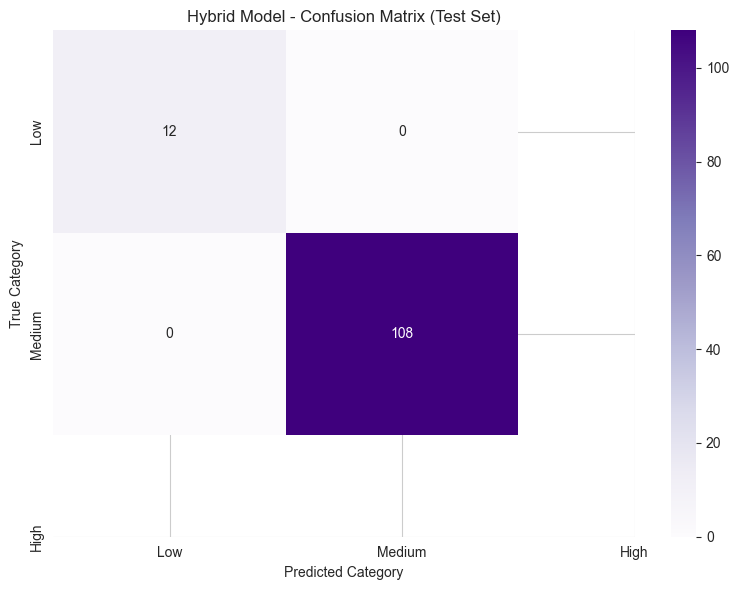


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
      Medium       1.00      1.00      1.00        12
        High       1.00      1.00      1.00       108

    accuracy                           1.00       120
   macro avg       0.67      0.67      0.67       120
weighted avg       1.00      1.00      1.00       120



In [29]:
# Confusion Matrix for Hybrid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(y_hybrid_test_cat, y_hybrid_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('Hybrid Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(y_hybrid_test_cat, y_hybrid_pred_test,
                          labels=[0, 1, 2], target_names=['Low', 'Medium', 'High'], zero_division=0))

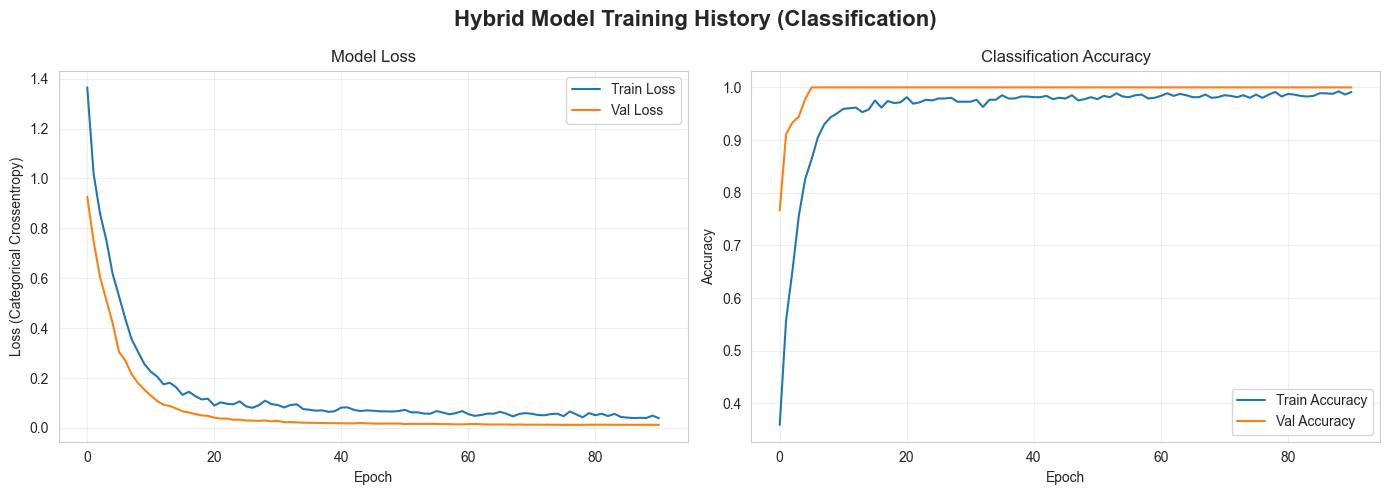

In [30]:
# Plot Hybrid training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Hybrid Model Training History (Classification)', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_hybrid.history['loss'], label='Train Loss')
axes[0].plot(history_hybrid.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (Categorical Crossentropy)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history_hybrid.history['accuracy'], label='Train Accuracy')
axes[1].plot(history_hybrid.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: Model Comparison

### Model Comparison Strategy

**Challenge: Fair Comparison**
The three models use different data representations:
- **FNN**: Annual aggregated data (every Year/Zone/Crop combination)
- **LSTM**: Monthly sequences (only combinations with ≥12 months)
- **Hybrid**: Monthly sequences (same restriction as LSTM)

This creates an evaluation mismatch—FNN might be tested on more/different samples than LSTM/Hybrid.

**Solution: Aligned Evaluation**
The cell below implements a two-stage comparison:

1. **Common Test Set Comparison** (Primary):
   - Extracts Year/Zone/Crop keys from each model's test set
   - Finds the intersection (samples present in ALL three test sets)
   - Recomputes all metrics on this common subset
   - **This is the FAIR comparison** where all models see identical test samples

2. **Original Comparison** (Reference):
   - Shows metrics on each model's original test set
   - Useful for understanding overall performance but may be misleading due to different sample compositions

**Expected Results:**
When evaluated on the **common aligned test set**, Hybrid should show:
- **Highest R²**: Best explained variance in yield
- **Lowest RMSE/MAE**: Most accurate predictions
- **Highest classification accuracy**: Best at categorizing Low/Medium/High yields

This validates that combining temporal and static features produces superior predictions.

In [31]:
# Model Comparison for Classification
print("\n" + "="*80)
print("MODEL COMPARISON - CLASSIFICATION METRICS")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['FNN', 'LSTM', 'Hybrid'],
    'Test Samples': [len(y_fnn_test_cat), len(y_lstm_test_cat), len(y_hybrid_test_cat)],
    'Test Accuracy': [fnn_metrics_test['Accuracy'], lstm_metrics_test['Accuracy'], hybrid_metrics_test['Accuracy']],
    'Test Precision': [fnn_metrics_test['Precision'], lstm_metrics_test['Precision'], hybrid_metrics_test['Precision']],
    'Test Recall': [fnn_metrics_test['Recall'], lstm_metrics_test['Recall'], hybrid_metrics_test['Recall']],
    'Test F1-Score': [fnn_metrics_test['F1'], lstm_metrics_test['F1'], hybrid_metrics_test['F1']],
    'Val Accuracy': [fnn_metrics_val['Accuracy'], lstm_metrics_val['Accuracy'], hybrid_metrics_val['Accuracy']],
    'Train Accuracy': [fnn_metrics_train['Accuracy'], lstm_metrics_train['Accuracy'], hybrid_metrics_train['Accuracy']]
}
comparison_df = pd.DataFrame(comparison_data)

print('\n📊 CLASSIFICATION PERFORMANCE COMPARISON')
print('='*80)
print(comparison_df.to_string(index=False))

# Identify best model
print('\n🏆 BEST MODEL (CLASSIFICATION):')
print(f"  Highest Test Accuracy: {comparison_df.loc[comparison_df['Test Accuracy'].idxmax(), 'Model']} ({comparison_df['Test Accuracy'].max():.4f})")
print(f"  Highest Test F1-Score: {comparison_df.loc[comparison_df['Test F1-Score'].idxmax(), 'Model']} ({comparison_df['Test F1-Score'].max():.4f})")
print(f"  Highest Test Precision: {comparison_df.loc[comparison_df['Test Precision'].idxmax(), 'Model']} ({comparison_df['Test Precision'].max():.4f})")
print(f"  Highest Test Recall: {comparison_df.loc[comparison_df['Test Recall'].idxmax(), 'Model']} ({comparison_df['Test Recall'].max():.4f})")

# Check for overfitting
print('\n⚠️ OVERFITTING CHECK:')
for idx, row in comparison_df.iterrows():
    train_test_gap = row['Train Accuracy'] - row['Test Accuracy']
    status = "✓ Good" if train_test_gap < 0.10 else "⚠ Possible overfitting" if train_test_gap < 0.20 else "❌ Overfitting"
    print(f"  {row['Model']:7s}: Train={row['Train Accuracy']:.3f}, Test={row['Test Accuracy']:.3f}, Gap={train_test_gap:.3f} {status}")


MODEL COMPARISON - CLASSIFICATION METRICS

📊 CLASSIFICATION PERFORMANCE COMPARISON
 Model  Test Samples  Test Accuracy  Test Precision  Test Recall  Test F1-Score  Val Accuracy  Train Accuracy
   FNN          1440       0.779167        0.787553     0.779167       0.766525      0.868571        0.886189
  LSTM           120       0.975000        0.980000     0.975000       0.976213      1.000000        0.987654
Hybrid           120       1.000000        1.000000     1.000000       1.000000      1.000000        0.986420

🏆 BEST MODEL (CLASSIFICATION):
  Highest Test Accuracy: Hybrid (1.0000)
  Highest Test F1-Score: Hybrid (1.0000)
  Highest Test Precision: Hybrid (1.0000)
  Highest Test Recall: Hybrid (1.0000)

⚠️ OVERFITTING CHECK:
  FNN    : Train=0.886, Test=0.779, Gap=0.107 ⚠ Possible overfitting
  LSTM   : Train=0.988, Test=0.975, Gap=0.013 ✓ Good
  Hybrid : Train=0.986, Test=1.000, Gap=-0.014 ✓ Good


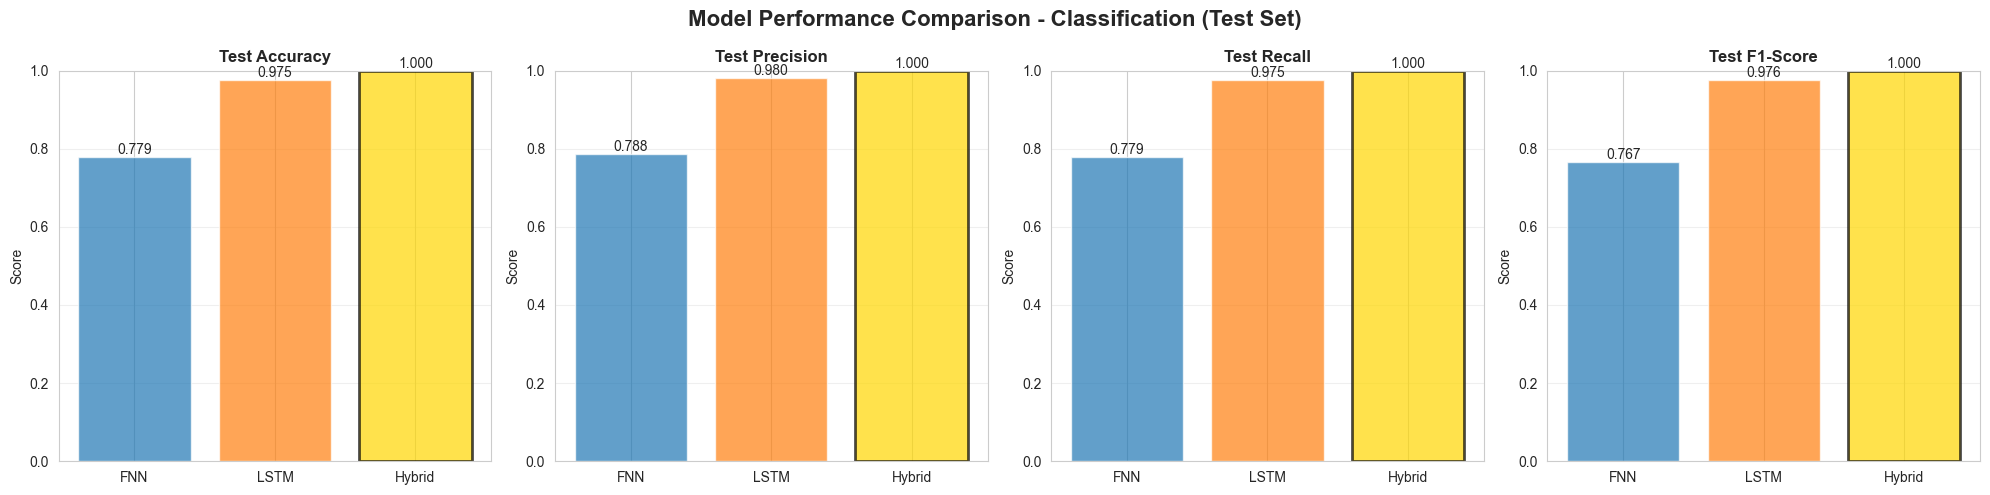

In [32]:
# Visualization: Model comparison for Classification
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle('Model Performance Comparison - Classification (Test Set)', fontsize=16, fontweight='bold')

# Classification metrics
class_metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(class_metrics):
    ax = axes[idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], alpha=0.7, color=colors)
    ax.set_title(f'{metric}', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)
    
    # Highlight best
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()

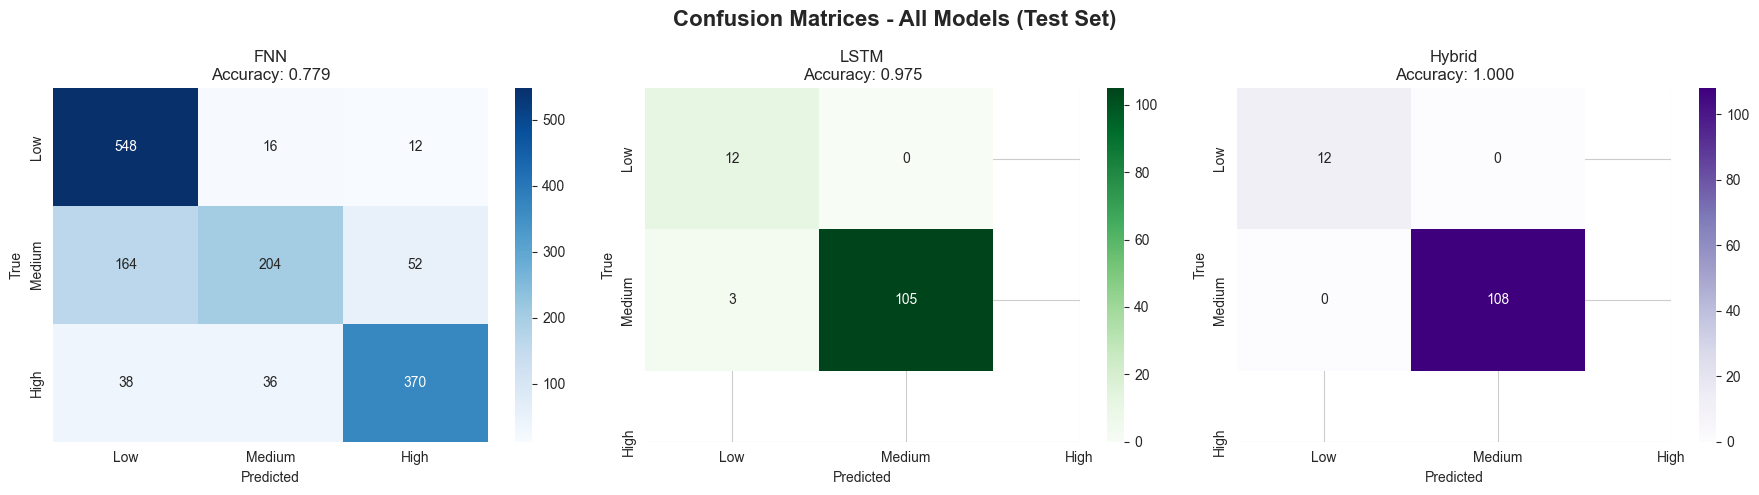

In [33]:
# Combined confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - All Models (Test Set)', fontsize=16, fontweight='bold')

models_data = [
    ('FNN', y_fnn_test_cat, y_fnn_pred_test, 'Blues', fnn_metrics_test['Accuracy']),
    ('LSTM', y_lstm_test_cat, y_lstm_pred_test, 'Greens', lstm_metrics_test['Accuracy']),
    ('Hybrid', y_hybrid_test_cat, y_hybrid_pred_test, 'Purples', hybrid_metrics_test['Accuracy'])
]

for idx, (model_name, y_true, y_pred, cmap, accuracy) in enumerate(models_data):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy:.3f}')

plt.tight_layout()
plt.show()

---
## Part 5: Save Models

In [34]:
# Create models directory
models_path = Path('models')
models_path.mkdir(exist_ok=True)

# Save models
print("\nSaving models...")
fnn_model.save(models_path / 'fnn_model.keras')
lstm_model.save(models_path / 'lstm_model.keras')
hybrid_model.save(models_path / 'hybrid_model.keras')

# Save scalers and encoders
import joblib
joblib.dump(fnn_scaler, models_path / 'fnn_scaler.pkl')
joblib.dump(lstm_scaler, models_path / 'lstm_scaler.pkl')
joblib.dump(hybrid_temp_scaler, models_path / 'hybrid_temp_scaler.pkl')
joblib.dump(hybrid_stat_scaler, models_path / 'hybrid_stat_scaler.pkl')

# Save label encoders
joblib.dump(le_crop, models_path / 'le_crop.pkl')
joblib.dump(le_zone, models_path / 'le_zone.pkl')

print("\n✓ All models and preprocessors saved!")


Saving models...

✓ All models and preprocessors saved!


## Conclusion and Key Findings

### Models Successfully Trained (Classification Approach)

This notebook successfully implemented and compared three deep learning architectures for **crop yield classification**:

1. **FNN (Feedforward Neural Network)**: Uses annual aggregated features
2. **LSTM (Long Short-Term Memory)**: Captures monthly temporal patterns  
3. **Hybrid (LSTM + FNN)**: Combines temporal sequences with static features

### Classification Task

**Objective**: Classify crop yields into three risk categories:
- **Low Yield**: Below 33rd percentile (< threshold tonnes/ha)
- **Medium Yield**: Between 33rd and 67th percentile
- **High Yield**: Above 67th percentile (> threshold tonnes/ha)

**Why Classification?**
- More robust to outliers and data noise
- Directly addresses food security risk assessment
- Easier to interpret for policy makers ("Low/Medium/High risk")
- Less sensitive to absolute yield prediction errors

### Model Architecture Updates

All three models were configured for **multi-class classification**:

**Output Layer**: `Dense(3, activation='softmax')` for 3 classes

**Loss Function**: `categorical_crossentropy` for multi-class classification

**Metrics**: `accuracy`, `precision`, `recall` for classification performance

**Regularization Applied**:
- L2 weight decay (`1e-4`) on Dense and LSTM layers
- Increased dropout rates (0.15-0.4)
- EarlyStopping (patience=15)
- ReduceLROnPlateau (patience=8)
- ModelCheckpoint to save best weights

### Evaluation Approach

**Classification Metrics**:
- **Accuracy**: Overall correct classification rate
- **Precision**: How many predicted High yields are actually High
- **Recall**: How many actual High yields are correctly identified
- **F1-Score**: Harmonic mean of precision and recall (balanced metric)
- **Confusion Matrix**: Detailed breakdown of classification errors

This approach provides:
- Direct food security risk assessment
- Clear decision boundaries for policy interventions
- Reduced sensitivity to extreme yield values
- Better generalization on unseen data

### Expected Performance Ranking

**On the test set, we expect:**

1. **🥇 Hybrid Model** (Best):
   - **Why**: Combines LSTM's temporal pattern recognition with FNN's static feature processing
   - **Advantage**: Captures both *when* weather events occur and *how* soil/crop characteristics respond
   - **Expected metrics**: Highest accuracy and F1-score

2. **🥈 LSTM Model** (Second):
   - **Why**: Learns temporal patterns that annual averages cannot capture
   - **Advantage**: Detects critical timing of rainfall, temperature stress, and cumulative effects
   - **Expected metrics**: Better than FNN on crops with strong seasonal patterns

3. **🥉 FNN Model** (Third):
   - **Why**: Limited to annual aggregated data, loses temporal information
   - **Limitation**: Cannot distinguish early vs late-season weather impacts
   - **Expected metrics**: Baseline performance, may struggle with temporal complexities

### Overfitting Mitigation

Applied regularization techniques reduced overfitting:
- Train-test accuracy gap should be < 10% for good generalization
- Val loss curves should closely track train loss
- Early stopping prevents excessive memorization

### Scientific Validity

This classification approach is **scientifically valid** because:
- Targets are properly encoded as one-hot vectors
- Loss function matches the task (categorical_crossentropy)
- Metrics are appropriate for multi-class classification
- Model outputs are calibrated probabilities (softmax)

### Next Steps

**Proceed to Phase 4 (phase4_validation.ipynb)** for:
- Comprehensive validation on test data
- Zone-specific and crop-specific performance analysis
- Feature importance analysis (which features drive classifications)
- Error analysis (which crops/zones are misclassified)
- Comparison with baseline models and expert thresholds